In [1]:
import tensorflow as tf
import datetime, os
#hide tf logs 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'} 
#0 (default) shows all, 1 to filter out INFO logs, 2 to additionally filter out WARNING logs, and 3 to additionally filter out ERROR logs
import scipy.optimize
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import seaborn as sns 
import codecs, json
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 

# generates same random numbers each time
np.random.seed(1234)
tf.random.set_seed(1234)

print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.9.1


# *Data Prep*

Training and Testing data is prepared from the solution file

In [2]:
## Data Import
K_real = np.load('./K_tx_real_d_one.npy') # Values of K(t,x)
Q_real = np.load('./Q_15minutes.npy') # Input Matrix of Model
f_real = Q_real[:,1] # Inflow Rate
v_real = Q_real[:,3] # Average Speed
pi_real = np.load('./pitilde_15minutes.npy') # Values of pi(t,x)

In [3]:
pi_real.shape

(150, 2016)

Text(0, 0.5, 'Remaining Trip Distance (miles)')

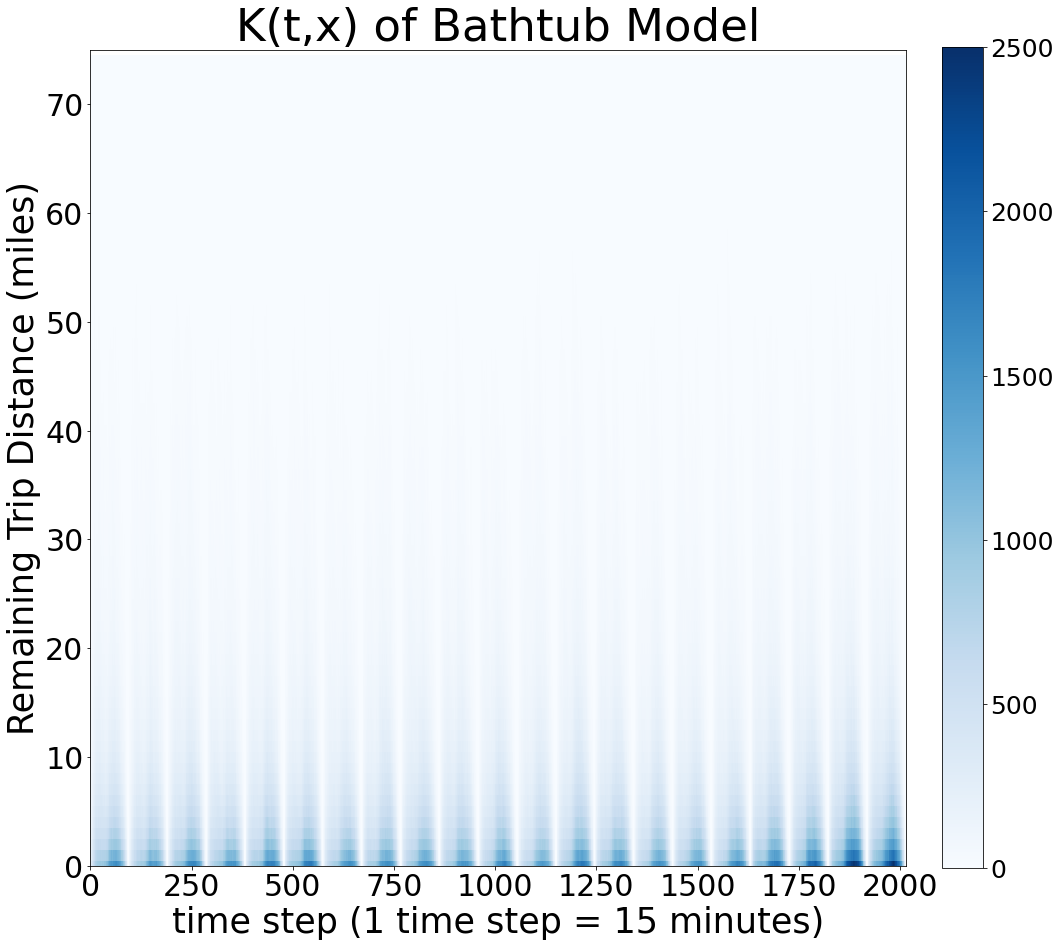

In [4]:
K_array = np.array(K_real[:,0:len(K_real[0])])
fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.T, cmap = 'Blues', interpolation='nearest')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,len(K_real[0])])
plt.clim(0, 2500) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title('K(t,x) of Bathtub Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (miles)', fontsize=35)

In [5]:
## Scale
N_timestep = 24*21*4 # 24 hours * 21 days * 15 minutes = total timestep
N_diststep = 75 # 1 distance step = 1 mile
Size_diststep = 1 # unit: miles
N_trainingdays = 0 # Set zero (0)
N_training = 24*4*N_trainingdays # Training data is all


## Normalization [0,1]
x = np.arange(0,int(N_diststep/Size_diststep))[:,None]   # x: step of remaining distance
t = np.arange(0,N_timestep)[:,None]    # Time step 
usol = K_real.transpose() [:,N_training:]     # real value of K(t,x) ==> Target Variable
usol_max = usol.max()

## Normalization [0,1]
x = (x - x.min()) / (x.max() - x.min())
t = (t - t.min()) / (t.max() - t.min())
f_real = (f_real - usol.min()) / (usol.max() - usol.min())  # usol과 같은 dimension이어야 함. 단위 같기 때문.
v_real = (v_real - v_real.min()) / (v_real.max() - v_real.min())
usol = (usol - usol.min()) / (usol.max()-usol.min())

X, T = np.meshgrid(x,t)                     # makes 2 arrays X and T such that u(X[i],T[j])=usol[i][j] are a tuple


multiplier_dist = int(N_diststep/Size_diststep)-1
multiplier_time = N_timestep-1
multiplier_u = usol_max
print('multiplier distance = ', multiplier_dist)
print('multiplier time = ', multiplier_time)
print('usol max = ', usol_max)

multiplier distance =  74
multiplier time =  2015
usol max =  2500


In [6]:
Size_diststep = 25 # unit: miles
Size_timestep = 2 # 2: 30min, 3: 60min
size_input = int(N_diststep/Size_diststep)*int(N_timestep/Size_timestep) # Total number of grid points
# size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
N_u = int(size_input*0.2) # Total number of data points for 'u' ==> Training data from grid points
N_f = N_u*2 #Total number of collocation (auxiliary) points 
alpha = 0.5 # weights of loss

print('size input = ', size_input)
print('N_u = ', N_u)
print('N_f = ', N_f)

size input =  3024
N_u =  604
N_f =  1208


In [7]:
# # Previous version (before Aug 30)
# size_input = int(N_diststep/Size_diststep)*N_timestep # All domain
# # size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
# N_u = int(size_input*0.5) #Total number of data points for 'u'
# N_f = N_u*2 #Total number of collocation points 
# alpha = 0.5

# print('size input = ', size_input)
# print('N_u = ', N_u)
# print('N_f = ', N_f)

# *Grid Data*

We prepare the grid data to compare against the solution produced by the PINN.

In [8]:
''' X_u_test = [X[i],T[i]] [25600,2] for interpolation'''
X_u_grid = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

# Domain bounds
lb = X_u_grid[0]  # [-1. 0.]
ub = X_u_grid[-1] # [1.  0.99]

'''
   Fortran Style ('F') flatten,stacked column wise!
   u = [c1 
        c2
        .
        .
        cn]

   u =  [25600x1] 
'''
u_grid = usol.flatten('F')[:,None] 

# *Training Data* (All domain)


The boundary conditions serve as the test data for the PINN and the collocation points are generated using **Latin Hypercube Sampling**

In [9]:
def trainingdata(N_u,N_f):

#     '''Boundary Conditions'''

#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 0  
#     leftedge_x = np.hstack((X[0,:][:,None], T[0,:][:,None])) #L1
#     leftedge_u = usol[:,0][:,None]
    
#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 2015  
#     rightedge_x = np.hstack((X[0,:][:,None], T[-1,:][:,None])) #L1
#     rightedge_u = usol[:,-1][:,None]

#     #Boundary Condition x = 9 (135 miles) and 0 =< t =<2015
#     topedge_x = np.hstack((X[:,-1][:,None], T[:,0][:,None])) #L3
#     topedge_u = usol[-1,:][:,None]
        
#     #Boundary Condition x = 0 and 0 =< t =<2015
#     bottomedge_x = np.hstack((X[:,0][:,None], T[:,0][:,None])) #L2
#     bottomedge_u = usol[0,:][:,None]
    
#     #Boundary Condition x = 5 (25 miles) and 0 =< t =<2015
#     midedge_x = np.hstack((X[:,5][:,None], T[:,0][:,None])) #L3
#     midedge_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 10 (50 miles) and 0 =< t =<2015
#     midedge1_x = np.hstack((X[:,10][:,None], T[:,0][:,None])) #L3
#     midedge1_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 15 (75 miles) and 0 =< t =<2015
#     midedge2_x = np.hstack((X[:,15][:,None], T[:,0][:,None])) #L3
#     midedge2_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 20 (100 miles) and 0 =< t =<2015
#     midedge3_x = np.hstack((X[:,20][:,None], T[:,0][:,None])) #L3
#     midedge3_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 25 (125 miles) and 0 =< t =<2015
#     midedge4_x = np.hstack((X[:,25][:,None], T[:,0][:,None])) #L3
#     midedge4_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 2 and 0 =< t =<2015
#     bottomedge_x_2 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_2 = usol[2,:][:,None]
    
#     #Boundary Condition x = 1 and 0 =< t =<2015
#     bottomedge_x_1 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_1 = usol[1,:][:,None]


#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x, midedge1_x, midedge2_x, midedge3_x, midedge4_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u, midedge1_u, midedge2_u, midedge3_u, midedge4_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([bottomedge_x, bottomedge_x_1, bottomedge_x_2]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, bottomedge_u_1, bottomedge_u_2])   #corresponding u [4042,]
    
#     all_X_u_train = np.vstack([bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, topedge_u])   #corresponding u [4042,]

    all_X_u_train = np.hstack((X.T[range(0,N_diststep,Size_diststep)][:,range(0,N_timestep,Size_timestep)].flatten()[:,None],T.T[range(0,N_diststep,Size_diststep)][:,range(0,N_timestep,Size_timestep)].flatten()[:,None]))
    all_u_train = usol[range(0,N_diststep,Size_diststep)][:,range(0,N_timestep,Size_timestep)].flatten()[:,None]
    
    #choose random N_u points for training
    np.random.seed(1234)
    train_idx = np.random.choice(all_X_u_train.shape[0], N_u, replace=False) # ID of training data
    test_idx = np.delete(np.arange(size_input), train_idx) # ID of testing data
    
    # Training Data
    X_u_train = all_X_u_train[train_idx, :] #choose indices from  set 'idx' (x,t)
    u_train = all_u_train[train_idx,:]      #choose corresponding u
    
    # Testing Data
    X_u_test = all_X_u_train[test_idx, :]
    u_test = all_u_train[test_idx,:]

    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
#     X_f_train = np.rint(lb + (ub-lb)*lhs(2,N_f))
    X_f_train = (lb + (ub-lb)*lhs(2,N_f))
#     X_f_train = np.unique(X_f_train, axis=0).astype(int) # 중복된 것 없앰
    X_f_train = np.vstack((X_f_train, X_u_train)) # append training points to collocation points 
    
    f_t = f_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    pi_tx = pi_real[np.int0(X_f_train*multiplier_dist)[:,0],np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    v_t = v_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]

    return X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx

In [10]:
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)

In [11]:
X_u_train.shape

(604, 2)

In [12]:
X_u_test.shape

(2420, 2)

In [13]:
X_u_train

array([[0.67567568, 0.52406948],
       [0.        , 0.08436725],
       [0.        , 0.35334988],
       ...,
       [0.        , 0.35831266],
       [0.        , 0.79801489],
       [0.67567568, 0.11215881]])

# **PINN**

Generate a **PINN** of L hidden layers, each with n neurons. 

Initialization: ***Xavier***

Activation: *tanh (x)*

In [14]:
class Sequentialmodel(tf.Module): 
    def __init__(self, layers, name=None):
       
        self.W = []  #Weights and biases
        self.parameters = 0 #total number of parameters
        
        for i in range(len(layers)-1):
            
            input_dim = layers[i]
            output_dim = layers[i+1]
            
            #Xavier standard deviation 
            std_dv = np.sqrt((2.0/(input_dim + output_dim)))

            #weights = normal distribution * Xavier standard deviation + 0
            w = tf.random.normal([input_dim, output_dim], dtype = 'float64') * std_dv
                       
            w = tf.Variable(w, trainable=True, name = 'w' + str(i+1))

            b = tf.Variable(tf.cast(tf.zeros([output_dim]), dtype = 'float64'), trainable = True, name = 'b' + str(i+1))
                    
            self.W.append(w)
            self.W.append(b)
            
            self.parameters +=  input_dim * output_dim + output_dim
    
    def evaluate(self,x):
        
        x = (x-lb)/(ub-lb)
        
        a = x
        
        for i in range(len(layers)-2):
            
            z = tf.add(tf.matmul(a, self.W[2*i]), self.W[2*i+1])
            a = tf.nn.tanh(z)
            
        a = tf.add(tf.matmul(a, self.W[-2]), self.W[-1]) # For regression, no activation to last layer
        return a
    
#     def speed(self,x):
        
#         a = tf.math.minimum(u_free, tf.abs(a_speed/x + b_speed))

#         print('speed = ', a)
#         print('k = ', x)

#         return a
    
    def get_weights(self):

        parameters_1d = []  # [.... W_i,b_i.....  ] 1d array
        
        for i in range (len(layers)-1):
            
            w_1d = tf.reshape(self.W[2*i],[-1])   #flatten weights 
            b_1d = tf.reshape(self.W[2*i+1],[-1]) #flatten biases
            
            parameters_1d = tf.concat([parameters_1d, w_1d], 0) #concat weights 
            parameters_1d = tf.concat([parameters_1d, b_1d], 0) #concat biases
        
        return parameters_1d
        
    def set_weights(self,parameters):
                
        for i in range (len(layers)-1):

            shape_w = tf.shape(self.W[2*i]).numpy() # shape of the weight tensor
            size_w = tf.size(self.W[2*i]).numpy() #size of the weight tensor 
            
            shape_b = tf.shape(self.W[2*i+1]).numpy() # shape of the bias tensor
            size_b = tf.size(self.W[2*i+1]).numpy() #size of the bias tensor 
                        
            pick_w = parameters[0:size_w] #pick the weights 
            self.W[2*i].assign(tf.reshape(pick_w,shape_w)) # assign  
            parameters = np.delete(parameters,np.arange(size_w),0) #delete 
            
            pick_b = parameters[0:size_b] #pick the biases 
            self.W[2*i+1].assign(tf.reshape(pick_b,shape_b)) # assign 
            parameters = np.delete(parameters,np.arange(size_b),0) #delete 

            
    def loss_BC(self,x,y):

        loss_u = tf.reduce_mean(tf.square(y-self.evaluate(x)))
        return loss_u
    
    def loss(self,x,y):

        loss_u = self.loss_BC(x,y)

        loss = loss_u

        return loss, loss_u
    
    def optimizerfunc(self,parameters):
        
        self.set_weights(parameters)
       
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            
            loss_val, loss_u= self.loss(X_u_train, u_train)
            
        grads = tape.gradient(loss_val,self.trainable_variables)
                
        del tape
        
        grads_1d = [ ] #flatten grads 
        
        for i in range (len(layers)-1):

            grads_w_1d = tf.reshape(grads[2*i],[-1]) #flatten weights 
            grads_b_1d = tf.reshape(grads[2*i+1],[-1]) #flatten biases

            grads_1d = tf.concat([grads_1d, grads_w_1d], 0) #concat grad_weights 
            grads_1d = tf.concat([grads_1d, grads_b_1d], 0) #concat grad_biases

        return loss_val.numpy(), grads_1d.numpy()
    
    def optimizer_callback(self,parameters):
               
        loss_value, loss_u = self.loss(X_u_train, u_train)
        
        u_pred = self.evaluate(X_u_test)
        error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)
        loss_record.append(loss_value)
        l2_record.append(error_vec)
        
        tf.print(loss_value, loss_u, error_vec)

# *Model Training and Testing*

A function '**model**' is defined to generate a NN as per the input set of hyperparameters, which is then trained and tested. The L2 Norm of the solution error is returned as a comparison metric

In [15]:
# Training data
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)
#alpha = int(N_f/N_u) #weight of loss function

layers = np.array([2,20,20,20,20,20,20,20,20,1]) #8 hidden layers
loss_record = []
l2_record = []

PINN = Sequentialmodel(layers)

init_params = PINN.get_weights().numpy()

start_time = time.time() 

# train the model with Scipy L-BFGS optimizer
results = scipy.optimize.minimize(fun = PINN.optimizerfunc, 
                                  x0 = init_params, 
                                  args=(), 
                                  method='L-BFGS-B', 
                                  jac= True,        # If jac is True, fun is assumed to return the gradient along with the objective function
                                  callback = PINN.optimizer_callback, 
                                  options = {'disp': None,
                                            'maxcor': 100, 
                                            'ftol': 1 * np.finfo(float).eps,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
#                                             'ftol': 1e-10,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
                                            'gtol': 1e-10, 
                                            'maxfun':  50000, 
                                            'maxiter': 15000,
                                            'iprint': -1,   #print update every 50 iterations
                                            'maxls': 50})
end_time = time.time()

0.044365877807292647 0.044365877807292647 0.7602828829307624
0.0338579432448403 0.0338579432448403 0.664996522157511
0.022755197346396312 0.022755197346396312 0.5630928459438291
0.02219412772506003 0.02219412772506003 0.5577221495313712
0.02207104029882764 0.02207104029882764 0.557495402440658
0.021965265429452284 0.021965265429452284 0.5560057198335152
0.021553014508053723 0.021553014508053723 0.5507591390957595
0.020838444571300064 0.020838444571300064 0.5409816903733525
0.020358546674441556 0.020358546674441556 0.5349709428699196
0.019551895358590917 0.019551895358590917 0.5244645244565306
0.018854593646992025 0.018854593646992025 0.5163260857764563
0.018325520445670474 0.018325520445670474 0.5125592783093443
0.018163672878554919 0.018163672878554919 0.5120724868943559
0.017930563754290883 0.017930563754290883 0.5089439502252608
0.017462055247259606 0.017462055247259606 0.502319919386976
0.016832134349681102 0.016832134349681102 0.4938743139516515
0.016204128290722489 0.016204128290

0.012373834652947006 0.012373834652947006 0.4316695384639198
0.012373144019350175 0.012373144019350175 0.4314235079153517
0.012372485187732924 0.012372485187732924 0.43141470337335347
0.012372343570360933 0.012372343570360933 0.431400890087055
0.012371955106428878 0.012371955106428878 0.43145026642162243
0.012371577085882005 0.012371577085882005 0.43142941860586936
0.012371388086614974 0.012371388086614974 0.4314030558649072
0.012371087583818257 0.012371087583818257 0.4313843325783349
0.012370947852582873 0.012370947852582873 0.43136854608230735
0.012370764106039685 0.012370764106039685 0.4313584889871636
0.012370484650673648 0.012370484650673648 0.4313445216471937
0.012370317525377286 0.012370317525377286 0.43137660677597756
0.012370196075719726 0.012370196075719726 0.4313624617828839
0.012370062201317953 0.012370062201317953 0.4313288057953133
0.01236990246106435 0.01236990246106435 0.4313349073971894
0.012369530799045566 0.012369530799045566 0.43134254955972295
0.012369410613994439 

0.012031449840672491 0.012031449840672491 0.4401625508561042
0.012029492302608686 0.012029492302608686 0.4402999971374848
0.012027441234625375 0.012027441234625375 0.44114447225571524
0.012022447815159735 0.012022447815159735 0.441491556801844
0.012020681315268185 0.012020681315268185 0.4408542172468644
0.012019394649689919 0.012019394649689919 0.44094387022321535
0.012018801614329029 0.012018801614329029 0.4412598509340263
0.012017888956212223 0.012017888956212223 0.441200663064303
0.012016839874033252 0.012016839874033252 0.44099519524178293
0.012016372839014274 0.012016372839014274 0.44095579205694513
0.012016085186145406 0.012016085186145406 0.44105299868155445
0.01201593893239759 0.01201593893239759 0.4410739879378165
0.012015877125749993 0.012015877125749993 0.441050044546903
0.012015808180243174 0.012015808180243174 0.44108857444270266
0.012015689735811751 0.012015689735811751 0.44112378901897015
0.012015549516269352 0.012015549516269352 0.441126988088373
0.012015286864979234 0.

0.011535641724838864 0.011535641724838864 0.45143930190069326
0.011534477699448537 0.011534477699448537 0.45143274500456665
0.01153313839042164 0.01153313839042164 0.4518035230888024
0.011532691041165723 0.011532691041165723 0.4516976034554489
0.011532088879711175 0.011532088879711175 0.45176146325311345
0.011531761089393387 0.011531761089393387 0.45151576831350665
0.011531343100377416 0.011531343100377416 0.451324983667524
0.011530964271793735 0.011530964271793735 0.4513164895224318
0.011530661293159388 0.011530661293159388 0.45097079494570624
0.011529808526698389 0.011529808526698389 0.45103672645929155
0.011529039290963983 0.011529039290963983 0.45114593700633204
0.011528525866547831 0.011528525866547831 0.4512367684239488
0.011527626937010907 0.011527626937010907 0.45148483707766346
0.011527526725295804 0.011527526725295804 0.451664888085429
0.011527083288116583 0.011527083288116583 0.45129514006439814
0.011526968858221694 0.011526968858221694 0.45128681318497177
0.0115268248558145

0.010824398337585202 0.010824398337585202 0.4580262911551415
0.010796926163098198 0.010796926163098198 0.4554228004252757
0.0107826922660628 0.0107826922660628 0.45433105540392366
0.010760229634376246 0.010760229634376246 0.45042214479321024
0.010737111346421063 0.010737111346421063 0.45145292774638873
0.010723199845972821 0.010723199845972821 0.45020532439439187
0.010694766568305364 0.010694766568305364 0.4500454862399545
0.010658896555471838 0.010658896555471838 0.4496170756257968
0.010610164944729659 0.010610164944729659 0.4504664109334545
0.010576911786250826 0.010576911786250826 0.449826275521876
0.010565309627903195 0.010565309627903195 0.4495907401421597
0.010554689860298467 0.010554689860298467 0.4484053003536822
0.010540972797203325 0.010540972797203325 0.44707842749319987
0.010523979792245916 0.010523979792245916 0.4454636967413697
0.010515665977336974 0.010515665977336974 0.4446911639163784
0.010506080497879898 0.010506080497879898 0.4443690235086667
0.010496576943042318 0.0

0.0097221520492506951 0.0097221520492506951 0.6638980840415108
0.0097213055421960983 0.0097213055421960983 0.6581312132017159
0.0097198416321985278 0.0097198416321985278 0.6389875478742145
0.0097187782265701766 0.0097187782265701766 0.6349230519953544
0.009717904512489127 0.009717904512489127 0.6376134693743665
0.0097173862979155 0.0097173862979155 0.630801381692403
0.0097166698324941073 0.0097166698324941073 0.6317540677295664
0.0097150264606641716 0.0097150264606641716 0.6311235757279888
0.0097124577142396161 0.0097124577142396161 0.6257768583702871
0.0097075872395547842 0.0097075872395547842 0.6146433279532464
0.0097026862297919618 0.0097026862297919618 0.5921688009999475
0.00969865790110597 0.00969865790110597 0.5916859473627915
0.0096966807812054554 0.0096966807812054554 0.5966100659177878
0.0096929148002922617 0.0096929148002922617 0.5917495257307771
0.0096913363902572432 0.0096913363902572432 0.5875009532374449
0.0096895469051951084 0.0096895469051951084 0.5889673139260104
0.009

0.0095945622954427649 0.0095945622954427649 0.6165210256415279
0.00959414126794926 0.00959414126794926 0.6151792758898695
0.0095940265699937088 0.0095940265699937088 0.6150551708466503
0.0095938542981564637 0.0095938542981564637 0.6140511430451137
0.0095937272401526 0.0095937272401526 0.6125173812553436
0.0095935307001391718 0.0095935307001391718 0.6089275154369794
0.00959331249206199 0.00959331249206199 0.606077524366866
0.0095931906165832963 0.0095931906165832963 0.6016177146750303
0.00959305456149935 0.00959305456149935 0.6009730816584956
0.0095929209196075112 0.0095929209196075112 0.6013058471834404
0.0095926938265943236 0.0095926938265943236 0.5995634950092821
0.0095924931290390821 0.0095924931290390821 0.5970525468685156
0.0095923637045833461 0.0095923637045833461 0.5950238256880342
0.00959219642655811 0.00959219642655811 0.594348777643784
0.0095919608580848151 0.0095919608580848151 0.591112163920841
0.0095916368728243134 0.0095916368728243134 0.5911857365887052
0.009591480883240

0.0095078092506172066 0.0095078092506172066 0.4916579273307682
0.0095058464280637373 0.0095058464280637373 0.48902079896918704
0.00950501661092359 0.00950501661092359 0.4851092009688054
0.00950414991129727 0.00950414991129727 0.4823263816638437
0.009503496723490594 0.009503496723490594 0.48084597491806674
0.009503223448777378 0.009503223448777378 0.4788435995192321
0.0095030061555014759 0.0095030061555014759 0.47782770382181844
0.0095023794514354325 0.0095023794514354325 0.47864782191519833
0.0095016804603630968 0.0095016804603630968 0.47956607089260894
0.0094997708962955389 0.0094997708962955389 0.4835545449844032
0.0094979096654004228 0.0094979096654004228 0.491184156589545
0.00949666130486915 0.00949666130486915 0.4926898744971155
0.0094956876993663869 0.0094956876993663869 0.4960458815496279
0.0094944234400588627 0.0094944234400588627 0.49802418576019086
0.0094940050445631 0.0094940050445631 0.495527544316702
0.0094935313237919945 0.0094935313237919945 0.4968003951276603
0.00949332

0.0093517858902206416 0.0093517858902206416 0.4293587364567034
0.0093505292793563538 0.0093505292793563538 0.42902757123505797
0.00934761003709552 0.00934761003709552 0.42621209777296437
0.0093443891156165752 0.0093443891156165752 0.42450679735466434
0.0093406282621882764 0.0093406282621882764 0.4220474993387151
0.0093391221075537125 0.0093391221075537125 0.4217962581391449
0.00933749959102623 0.00933749959102623 0.4206602182069945
0.00933633402355003 0.00933633402355003 0.419986748217898
0.0093345568045381869 0.0093345568045381869 0.41902983820744977
0.0093327852024687515 0.0093327852024687515 0.4191527281484312
0.0093313867161827629 0.0093313867161827629 0.41783766904100555
0.0093298744115387546 0.0093298744115387546 0.41726010018456694
0.0093272076686686124 0.0093272076686686124 0.4152520099526176
0.0093250942949372334 0.0093250942949372334 0.4140877745823307
0.0093235136080807024 0.0093235136080807024 0.4127153735589913
0.0093227881020029532 0.0093227881020029532 0.4121243601126982

0.0092636019972174855 0.0092636019972174855 0.46322969246784274
0.0092631865779278771 0.0092631865779278771 0.4622481730331819
0.0092624584511194225 0.0092624584511194225 0.4644768863807707
0.0092615569674041366 0.0092615569674041366 0.4645745371222372
0.0092609917424066324 0.0092609917424066324 0.46336199843965137
0.009260335717137887 0.009260335717137887 0.4641449277392407
0.0092597102368985936 0.0092597102368985936 0.46720631331341406
0.00925903006298815 0.00925903006298815 0.4684212212555456
0.0092587056944956319 0.0092587056944956319 0.47004697096935183
0.0092583034108120951 0.0092583034108120951 0.4721312980164174
0.0092579660893125 0.0092579660893125 0.472421160009407
0.0092576456348090752 0.0092576456348090752 0.47193715740843684
0.0092572737489539387 0.0092572737489539387 0.4713942233518993
0.0092569394693144975 0.0092569394693144975 0.4720702937377061
0.0092565896245770281 0.0092565896245770281 0.46897488140906984
0.0092561876799588817 0.0092561876799588817 0.4687028225506933

0.0092034274926797 0.0092034274926797 0.4200061994345802
0.0092033860182650622 0.0092033860182650622 0.42050390881529714
0.00920314106265092 0.00920314106265092 0.4195884042272462
0.0092030968450015366 0.0092030968450015366 0.41846165999455387
0.0092030322607916937 0.0092030322607916937 0.4184278598519858
0.0092030100613018934 0.0092030100613018934 0.418141018241514
0.0092029792293140018 0.0092029792293140018 0.4180463167390892
0.0092029657146528825 0.0092029657146528825 0.41772425573949923
0.00920294376186842 0.00920294376186842 0.4175938817225906
0.0092028926546942284 0.0092028926546942284 0.417561892988612
0.0092027753044129929 0.0092027753044129929 0.4173286845992128
0.0092026124722930872 0.0092026124722930872 0.4172812905925977
0.0092024471689032637 0.0092024471689032637 0.417413262394443
0.0092022389907598281 0.0092022389907598281 0.41799227978980974
0.0092020662939276375 0.0092020662939276375 0.4179672068378722
0.0092017998085322985 0.0092017998085322985 0.41809325911318296
0.00

0.0091676966312510717 0.0091676966312510717 0.4179145469507693
0.0091676728602287857 0.0091676728602287857 0.4178406907670082
0.0091676570642645772 0.0091676570642645772 0.41770817353963685
0.0091676468626890727 0.0091676468626890727 0.41771716709530843
0.0091676174906648467 0.0091676174906648467 0.4176969552729106
0.0091675777082038355 0.0091675777082038355 0.4176471804946251
0.00916752866856706 0.00916752866856706 0.417573448735929
0.0091674903096975579 0.0091674903096975579 0.4175076148188766
0.00916743594817006 0.00916743594817006 0.4175470480691921
0.0091673299079879974 0.0091673299079879974 0.4174515947420547
0.0091672006081423927 0.0091672006081423927 0.4174389034944893
0.0091669048271625954 0.0091669048271625954 0.4175241895037503
0.00916673274208129 0.00916673274208129 0.41757192150770645
0.0091665090112014718 0.0091665090112014718 0.4178591694027999
0.0091663882155955546 0.0091663882155955546 0.4177602874401071
0.00916605063694673 0.00916605063694673 0.417666550794503
0.00916

0.0091546384736379081 0.0091546384736379081 0.41516489741382756
0.0091546144040694759 0.0091546144040694759 0.4151856549722584
0.009154582433195153 0.009154582433195153 0.415101114818414
0.0091545351644866831 0.0091545351644866831 0.4148552726056818
0.009154504446580957 0.009154504446580957 0.4146175660655511
0.0091544419370632873 0.0091544419370632873 0.41448984807390504
0.0091543667185245512 0.0091543667185245512 0.4143878267280872
0.0091542692894364432 0.0091542692894364432 0.4144609091071134
0.0091542209246719738 0.0091542209246719738 0.41432529991280775
0.0091541058752656473 0.0091541058752656473 0.41449387463205584
0.0091540445810776028 0.0091540445810776028 0.4145188612738382
0.0091540009820696919 0.0091540009820696919 0.4144155585028263
0.0091539747458041654 0.0091539747458041654 0.41439023246294704
0.0091539565688574572 0.0091539565688574572 0.4143230352445234
0.0091539366653293538 0.0091539366653293538 0.4143093224758315
0.00915389654984235 0.00915389654984235 0.4142245982743

0.0091514559472522152 0.0091514559472522152 0.41225164159447664
0.0091514414511389853 0.0091514414511389853 0.41232240433896256
0.0091514259556664118 0.0091514259556664118 0.41231815564293345
0.0091514059675172742 0.0091514059675172742 0.41228455700145256
0.00915138803724115 0.00915138803724115 0.4122739549024234
0.009151367287323112 0.009151367287323112 0.41233453416533394
0.0091513426543558644 0.0091513426543558644 0.41233243592689506
0.0091513122454792723 0.0091513122454792723 0.41237694733781705
0.0091513039661357924 0.0091513039661357924 0.4123882578324084
0.0091512873413553 0.0091512873413553 0.41240625971679934
0.009151266564524552 0.009151266564524552 0.41249380419226855
0.0091512595656467709 0.0091512595656467709 0.41248002142938417
0.0091512418966310845 0.0091512418966310845 0.41242840784765866
0.00915121738464536 0.00915121738464536 0.4124160369104105
0.0091511872298110485 0.0091511872298110485 0.4123387133849905
0.009151165677601672 0.009151165677601672 0.4123003575740657
0

0.0091393042052540212 0.0091393042052540212 0.411852189746418
0.0091392395350131765 0.0091392395350131765 0.41181376292935157
0.0091391635295991411 0.0091391635295991411 0.41176787745056603
0.0091390992167986167 0.0091390992167986167 0.4118020869809224
0.0091390216389211233 0.0091390216389211233 0.411831452866952
0.0091389195908409011 0.0091389195908409011 0.4118599576012773
0.0091388465495763366 0.0091388465495763366 0.4118476643822034
0.00913870757340813 0.00913870757340813 0.4118280756709194
0.0091385495338939336 0.0091385495338939336 0.41188442374148204
0.0091384465413459747 0.0091384465413459747 0.4117821222354816
0.0091383606882228068 0.0091383606882228068 0.41169072959193415
0.0091382319670886315 0.0091382319670886315 0.4115789468609526
0.0091380742466147576 0.0091380742466147576 0.41128374260649303
0.009137837074925919 0.009137837074925919 0.41134267268717967
0.0091376905198573034 0.0091376905198573034 0.41126543688373446
0.0091375669999242438 0.0091375669999242438 0.4110772496

0.0091241697391930953 0.0091241697391930953 0.41960409657870806
0.00912411939904268 0.00912411939904268 0.41966069050285193
0.0091240338001595134 0.0091240338001595134 0.42024628062782793
0.0091239183776754291 0.0091239183776754291 0.4209812593932716
0.009123812956965972 0.009123812956965972 0.42170358166963523
0.009123691295992109 0.009123691295992109 0.42244750294018646
0.0091235692483580787 0.0091235692483580787 0.4230788185638458
0.0091235151567398524 0.0091235151567398524 0.4230788560569947
0.0091234513260032221 0.0091234513260032221 0.4232810202249604
0.0091233886130373844 0.0091233886130373844 0.42358703222432664
0.0091232843454808 0.0091232843454808 0.4251861659465607
0.0091232196335261171 0.0091232196335261171 0.42581183494222985
0.0091230850254740512 0.0091230850254740512 0.42743491801210026
0.0091229633721862779 0.0091229633721862779 0.42905119321754603
0.0091229096955239373 0.0091229096955239373 0.43072455442066143
0.0091228209394170114 0.0091228209394170114 0.4315372694844

0.009114832375850878 0.009114832375850878 0.4523353706187983
0.0091147479839274754 0.0091147479839274754 0.4522490811553512
0.0091146714268344683 0.0091146714268344683 0.45285601409573983
0.0091144952795997845 0.0091144952795997845 0.4533776480642698
0.0091144188555876745 0.0091144188555876745 0.452945207946318
0.009114344484532 0.009114344484532 0.45285791511968887
0.00911425283827727 0.00911425283827727 0.45306347284856896
0.0091141512230284664 0.0091141512230284664 0.4528957815081337
0.0091140715024428491 0.0091140715024428491 0.4528467225514476
0.0091139118098472888 0.0091139118098472888 0.451151633415676
0.0091138527125197363 0.0091138527125197363 0.4512899728378628
0.0091137914843859042 0.0091137914843859042 0.45010998265778607
0.0091136985709848253 0.0091136985709848253 0.449490679173209
0.0091136446437313327 0.0091136446437313327 0.4491255585946379
0.0091135640295628446 0.0091135640295628446 0.448111352250993
0.0091134586414230931 0.0091134586414230931 0.44648927310991676
0.009

0.0090903045241689431 0.0090903045241689431 0.43623773954956585
0.00908959875015831 0.00908959875015831 0.43569942129483075
0.00908913055101005 0.00908913055101005 0.43488437039497296
0.00908834111530268 0.00908834111530268 0.43571238958981195
0.0090880062844429649 0.0090880062844429649 0.4364369518406988
0.00908722180118023 0.00908722180118023 0.43687015033511123
0.0090860514326362284 0.0090860514326362284 0.43897360747668257
0.00908576599856264 0.00908576599856264 0.4394001347465966
0.0090848472067900487 0.0090848472067900487 0.4397908402761188
0.0090843018811822759 0.0090843018811822759 0.4408935124280345
0.00908419464781575 0.00908419464781575 0.44184114336633046
0.0090837007973510724 0.0090837007973510724 0.44230894792718345
0.0090835756930503046 0.0090835756930503046 0.4426861772789469
0.0090832216115506459 0.0090832216115506459 0.44347401822685134
0.0090830608665277666 0.0090830608665277666 0.44412980872588587
0.0090827462412622264 0.0090827462412622264 0.4450948869762108
0.0090

0.0090220901056851932 0.0090220901056851932 0.4838283136266995
0.0090216707316507078 0.0090216707316507078 0.4863082091562729
0.0090213954224750755 0.0090213954224750755 0.48644837809478786
0.0090212345514320922 0.0090212345514320922 0.4880233037107115
0.0090210638985227763 0.0090210638985227763 0.4874225570062831
0.00902055862675367 0.00902055862675367 0.4864977786312474
0.0090196964622710155 0.0090196964622710155 0.48567287678218396
0.0090188396099158061 0.0090188396099158061 0.48797685855351425
0.0090179783811018977 0.0090179783811018977 0.4882995997012063
0.0090169503460013171 0.0090169503460013171 0.4920810502264946
0.0090162300045242578 0.0090162300045242578 0.49301142453297375
0.0090159021051801624 0.0090159021051801624 0.4942176601987826
0.0090156791804606434 0.0090156791804606434 0.49439823230215446
0.0090153437794031725 0.0090153437794031725 0.4961211016527269
0.0090151083782075512 0.0090151083782075512 0.49758161641954723
0.0090145245284331214 0.0090145245284331214 0.4999103

0.00898398770486323 0.00898398770486323 0.5175884696147262
0.00898365885324421 0.00898365885324421 0.5160869273607614
0.0089833044743830356 0.0089833044743830356 0.515627046288228
0.008982844926762823 0.008982844926762823 0.5121475347237502
0.00898264789126187 0.00898264789126187 0.510011313497733
0.0089826136588731283 0.0089826136588731283 0.5106787187184929
0.0089823630166308167 0.0089823630166308167 0.5089936455451733
0.0089821990863731948 0.0089821990863731948 0.507694282106661
0.0089819092333989058 0.0089819092333989058 0.5060799499994513
0.0089810887461026 0.0089810887461026 0.5044489297243169
0.0089801548986357081 0.0089801548986357081 0.5082474126063873
0.00897876527322264 0.00897876527322264 0.509085784517226
0.0089777586972982614 0.0089777586972982614 0.5107962872442734
0.0089768417090497869 0.0089768417090497869 0.5146155512277742
0.0089761737952415745 0.0089761737952415745 0.5216561537735858
0.0089759332860851089 0.0089759332860851089 0.5233134265751006
0.008975750377926751

0.0089105907819372991 0.0089105907819372991 0.4211937110765121
0.0089101248249719919 0.0089101248249719919 0.4212428595235471
0.0089097616213046783 0.0089097616213046783 0.41926272070629617
0.0089097343082316423 0.0089097343082316423 0.4196320555572889
0.0089095413470817227 0.0089095413470817227 0.41963233547183093
0.008909418883808631 0.008909418883808631 0.4192294516755928
0.0089092197517939738 0.0089092197517939738 0.41929586539622066
0.0089083631653091317 0.0089083631653091317 0.4194728547620843
0.0089076133604327253 0.0089076133604327253 0.4198589142168733
0.0089068022964900219 0.0089068022964900219 0.42115845449358275
0.0089065035601815518 0.0089065035601815518 0.42179666011400463
0.0089062823681479233 0.0089062823681479233 0.42175389617095166
0.0089061089642309844 0.0089061089642309844 0.4213775603844442
0.00890583955827977 0.00890583955827977 0.42159747737424885
0.0089053289041227772 0.0089053289041227772 0.422041326182483
0.0089049796723903243 0.0089049796723903243 0.422182831

0.0088418581974006264 0.0088418581974006264 0.5099878208698841
0.00884098056602865 0.00884098056602865 0.5114105688289795
0.00884006661077313 0.00884006661077313 0.5147078842798641
0.0088392489006586458 0.0088392489006586458 0.519042753175455
0.0088383523882462223 0.0088383523882462223 0.520485072134076
0.0088370483551133121 0.0088370483551133121 0.5212013379688252
0.0088358383128760119 0.0088358383128760119 0.5203351518643964
0.0088351662912251275 0.0088351662912251275 0.5174277379466354
0.0088338942878848845 0.0088338942878848845 0.5161132024578576
0.0088331204619723387 0.0088331204619723387 0.5153067997014716
0.0088319424168042653 0.0088319424168042653 0.514704858161304
0.0088309767193006979 0.0088309767193006979 0.5150674721694413
0.0088292809869666231 0.0088292809869666231 0.5158731353454171
0.00882836283447109 0.00882836283447109 0.5182396784006266
0.008825830493846271 0.008825830493846271 0.5152861351692006
0.00882401840755971 0.00882401840755971 0.5136856350281772
0.00882262868

0.008758767763322366 0.008758767763322366 0.4655296792419018
0.0087586496668046049 0.0087586496668046049 0.4659610101573076
0.0087585026438021362 0.0087585026438021362 0.4672695688811945
0.0087583298101917284 0.0087583298101917284 0.46766100764492446
0.008758019985479204 0.008758019985479204 0.47111512681137224
0.0087578342605396983 0.0087578342605396983 0.47204171875590145
0.0087576899729074273 0.0087576899729074273 0.4738588134642095
0.0087575687338886359 0.0087575687338886359 0.47706701821272923
0.00875749020370007 0.00875749020370007 0.48244171009027864
0.0087572727893158453 0.0087572727893158453 0.4821124832578436
0.0087570909702878036 0.0087570909702878036 0.48199758752240174
0.0087568243892472784 0.0087568243892472784 0.482684165943955
0.0087567009447177564 0.0087567009447177564 0.48346191375248065
0.0087564020956065868 0.0087564020956065868 0.483311023374469
0.008756097088998778 0.008756097088998778 0.48176468627416413
0.0087556629055604591 0.0087556629055604591 0.4810267340757

0.0087319796650893022 0.0087319796650893022 0.48668365025114807
0.0087319083987390418 0.0087319083987390418 0.4873419755372117
0.0087318529460294024 0.0087318529460294024 0.48836746152946264
0.0087318087398708059 0.0087318087398708059 0.48990518372834774
0.0087317470068620073 0.0087317470068620073 0.4896105881834678
0.0087316779966324937 0.0087316779966324937 0.4902885547216981
0.00873158133095189 0.00873158133095189 0.49135094770505
0.0087315235603212058 0.0087315235603212058 0.49319268594142346
0.0087314451886690812 0.0087314451886690812 0.4923601845316279
0.0087313639652290085 0.0087313639652290085 0.49241872558615374
0.0087311864536617489 0.0087311864536617489 0.4930421687246274
0.0087311249232661665 0.0087311249232661665 0.49466534414981506
0.0087309555106668581 0.0087309555106668581 0.49539036836557804
0.0087306499082876691 0.0087306499082876691 0.4991852825056527
0.0087304078861885886 0.0087304078861885886 0.5013217569593932
0.0087302516816961887 0.0087302516816961887 0.50583779

0.0086936568315282188 0.0086936568315282188 0.44058070128650645
0.0086934534835577514 0.0086934534835577514 0.44249329720890707
0.00869318467128914 0.00869318467128914 0.44690497547014085
0.0086928991163200773 0.0086928991163200773 0.45224979461731585
0.0086922748217409442 0.0086922748217409442 0.45166086206905187
0.0086917834482332715 0.0086917834482332715 0.4475306645886953
0.0086909547108525737 0.0086909547108525737 0.4501197412938295
0.0086902044028319275 0.0086902044028319275 0.4508650062267631
0.0086889363198848386 0.0086889363198848386 0.44998098775762096
0.00868821986222176 0.00868821986222176 0.4525613858602029
0.0086878111921084161 0.0086878111921084161 0.4538995350104945
0.0086873617631277912 0.0086873617631277912 0.4603965180523769
0.00868698184394078 0.00868698184394078 0.4538328636943859
0.0086867374256880871 0.0086867374256880871 0.4531706615703069
0.008686482873312959 0.008686482873312959 0.45260306042844534
0.00868611584330705 0.00868611584330705 0.4520426072875106
0.0

0.0086160683320604566 0.0086160683320604566 0.4418595285830866
0.0086157335991000686 0.0086157335991000686 0.44404546481960866
0.0086155422006411238 0.0086155422006411238 0.44618428915279196
0.00861532327666429 0.00861532327666429 0.4476412008172487
0.0086151246449004976 0.0086151246449004976 0.44884847531851446
0.0086148087204517311 0.0086148087204517311 0.45233890953294187
0.0086144009556917839 0.0086144009556917839 0.45934544270540595
0.0086139227897186581 0.0086139227897186581 0.46642278463399767
0.008613279456111813 0.008613279456111813 0.4706632145929478
0.0086126349622372769 0.0086126349622372769 0.479212540154389
0.0086118643777975627 0.0086118643777975627 0.49261735134228085
0.00861126096337183 0.00861126096337183 0.5030926355910035
0.0086107538571831149 0.0086107538571831149 0.5031816066236343
0.00860985423780202 0.00860985423780202 0.5130853776326191
0.0086088386842440474 0.0086088386842440474 0.5184932704314082
0.0086081252157694573 0.0086081252157694573 0.5335719573882266


0.0085106438152290319 0.0085106438152290319 2.0761014788748424
0.0085099228723357553 0.0085099228723357553 2.0984143022851667
0.0085093849019949458 0.0085093849019949458 2.1296826587961113
0.008508958992603146 0.008508958992603146 2.1496626502009333
0.0085086029683807528 0.0085086029683807528 2.1565740320221374
0.0085084322641330659 0.0085084322641330659 2.161560158282819
0.0085082264220021023 0.0085082264220021023 2.16042398464766
0.0085075671319937551 0.0085075671319937551 2.181035586099753
0.0085063739590334857 0.0085063739590334857 2.1962597623873155
0.0085051261043123938 0.0085051261043123938 2.232849150299054
0.0085038440161177252 0.0085038440161177252 2.2474567735562125
0.0085021643369172333 0.0085021643369172333 2.2639786336927146
0.008501635582357895 0.008501635582357895 2.2482536424575295
0.008498773285042633 0.008498773285042633 2.2673961086490673
0.00849771412861994 0.00849771412861994 2.2743223568245163
0.00849631855214982 0.00849631855214982 2.2560494406254494
0.008495176

0.0084460976877874447 0.0084460976877874447 2.4071637393029355
0.00844406341028251 0.00844406341028251 2.425073263843836
0.0084412135642189454 0.0084412135642189454 2.4643704462169933
0.0084398071279555946 0.0084398071279555946 2.433670848843819
0.0084375330088297743 0.0084375330088297743 2.433520153625756
0.008434827473532679 0.008434827473532679 2.456648122177459
0.0084335748482483163 0.0084335748482483163 2.447464732174526
0.0084331471944947712 0.0084331471944947712 2.4324082590176546
0.0084321111254803925 0.0084321111254803925 2.4290657326612024
0.0084309700670054874 0.0084309700670054874 2.4177758182783666
0.0084298608106533612 0.0084298608106533612 2.419962493743952
0.0084284426030304654 0.0084284426030304654 2.4232690642180583
0.0084270114231895839 0.0084270114231895839 2.42826038755605
0.00842636050393815 0.00842636050393815 2.430024281957974
0.008425341015318423 0.008425341015318423 2.4542136815778095
0.00842397587553158 0.00842397587553158 2.4603964711563933
0.008423083015532

0.0083758305987388874 0.0083758305987388874 3.0749707661230015
0.00837577033193332 0.00837577033193332 3.0656825423325142
0.00837568803749954 0.00837568803749954 3.0609985977936183
0.0083755896589415967 0.0083755896589415967 3.053885968751668
0.0083754970613303635 0.0083754970613303635 3.0369379982494897
0.00837541518534036 0.00837541518534036 3.0202805981163663
0.0083753369374894911 0.0083753369374894911 3.0024312390016314
0.0083752518602784355 0.0083752518602784355 2.9849308806455226
0.0083751681803163353 0.0083751681803163353 2.965035945089368
0.0083751048712984947 0.0083751048712984947 2.9457489448229897
0.0083750686822598955 0.0083750686822598955 2.9431586745491773
0.0083750346310219655 0.0083750346310219655 2.9352288813159206
0.0083749967961504659 0.0083749967961504659 2.933818262631253
0.0083749240117799821 0.0083749240117799821 2.925327547372397
0.0083747758208871873 0.0083747758208871873 2.9055407235486275
0.0083745948440593927 0.0083745948440593927 2.8960876773439885
0.008374

0.0083480567160482515 0.0083480567160482515 2.659997245072948
0.00834760738894502 0.00834760738894502 2.680932722262919
0.008347094856244585 0.008347094856244585 2.7066196515300165
0.0083466943080397517 0.0083466943080397517 2.726894440955815
0.0083459559955119441 0.0083459559955119441 2.739608630567534
0.00834554355183759 0.00834554355183759 2.747874394909283
0.00834449051225361 0.00834449051225361 2.7719698463670093
0.008344026669698126 0.008344026669698126 2.7997313627037554
0.0083431368467428019 0.0083431368467428019 2.8719112778182563
0.0083422366983491418 0.0083422366983491418 2.89593049174122
0.00834187247258593 0.00834187247258593 2.894315401356354
0.008341537426259588 0.008341537426259588 2.9307296888048735
0.0083411446457557683 0.0083411446457557683 2.956227171477927
0.008340859044295797 0.008340859044295797 2.9680518357381005
0.0083406578028184415 0.0083406578028184415 2.983765244308697
0.00834046665393528 0.00834046665393528 3.0044594750491336
0.0083403974832062678 0.008340

0.0083226021747099411 0.0083226021747099411 2.6137836596074044
0.0083224611747841487 0.0083224611747841487 2.613836056990887
0.0083222924390696975 0.0083222924390696975 2.6186441053522636
0.0083220607427467782 0.0083220607427467782 2.625732818044757
0.0083218103943967659 0.0083218103943967659 2.648343016324739
0.0083216393961521151 0.0083216393961521151 2.6752258881216013
0.0083213069023414989 0.0083213069023414989 2.680722362324242
0.00832106341784155 0.00832106341784155 2.697632371865619
0.0083207593226312521 0.0083207593226312521 2.723546268555616
0.0083206464150741358 0.0083206464150741358 2.731758952706252
0.0083204283047763113 0.0083204283047763113 2.757910299910257
0.0083201483514048821 0.0083201483514048821 2.784324100919539
0.0083199612027417148 0.0083199612027417148 2.790368478134329
0.0083197365777807428 0.0083197365777807428 2.80384175887888
0.0083196683836776631 0.0083196683836776631 2.818212158409951
0.00831960019236304 0.00831960019236304 2.8215220664867675
0.00831954932

0.0082952885121060742 0.0082952885121060742 2.733403331654955
0.0082950689143970156 0.0082950689143970156 2.712025129106725
0.0082949571139175581 0.0082949571139175581 2.7199607709759506
0.0082948609670652 0.0082948609670652 2.7204307830754932
0.008294767756319342 0.008294767756319342 2.7051492088687543
0.0082946693463133731 0.0082946693463133731 2.699688710781408
0.0082945156665921484 0.0082945156665921484 2.6863143740588296
0.008294333080092 0.008294333080092 2.668982142308857
0.0082942234322391541 0.0082942234322391541 2.6627758611717556
0.00829409478153287 0.00829409478153287 2.648645900814099
0.00829396829829486 0.00829396829829486 2.65787440013816
0.0082938723901605834 0.0082938723901605834 2.639472742584129
0.0082936977142843513 0.0082936977142843513 2.6346901165194754
0.0082935471314528365 0.0082935471314528365 2.6170155279668106
0.0082933471559426316 0.0082933471559426316 2.592998068824832
0.008293194035549796 0.008293194035549796 2.5772940570996896
0.0082930229039658351 0.008

0.0082783464814981719 0.0082783464814981719 1.9484334062880042
0.00827811459989152 0.00827811459989152 1.9449086111924914
0.0082779325086167754 0.0082779325086167754 1.941901007400758
0.0082776787469360132 0.0082776787469360132 1.9430479568804782
0.0082774884256746582 0.0082774884256746582 1.9243873225997732
0.0082773799367511745 0.0082773799367511745 1.9128801500674906
0.00827722970204378 0.00827722970204378 1.9154723883096005
0.00827714388323444 0.00827714388323444 1.91359251096877
0.0082770527804949014 0.0082770527804949014 1.903402675401925
0.0082768793909439309 0.0082768793909439309 1.8959000586825465
0.0082768147221598445 0.0082768147221598445 1.8977700299205842
0.008276569000509798 0.008276569000509798 1.892330921242059
0.0082764483649441518 0.0082764483649441518 1.8858064512252064
0.0082763390005431772 0.0082763390005431772 1.8875220649677378
0.0082761865637387983 0.0082761865637387983 1.884223730106359
0.0082761008168187721 0.0082761008168187721 1.8888806655325028
0.0082759534

0.0082325861594931618 0.0082325861594931618 1.321921512714463
0.0082320918870407347 0.0082320918870407347 1.2935000820280307
0.0082316936514456 0.0082316936514456 1.264228282264627
0.0082315266296901484 0.0082315266296901484 1.2575424992653004
0.0082307228945447952 0.0082307228945447952 1.2613106022066778
0.0082304121380323246 0.0082304121380323246 1.2460861433439603
0.008229997973611217 0.008229997973611217 1.2542636359555412
0.0082295938959673041 0.0082295938959673041 1.2476929504949026
0.0082292065807631314 0.0082292065807631314 1.235002194337213
0.0082288162072867658 0.0082288162072867658 1.2259479038136014
0.0082280265017431464 0.0082280265017431464 1.2068487379101729
0.0082273422905730365 0.0082273422905730365 1.1838251168631346
0.0082271615892605746 0.0082271615892605746 1.1779632323939098
0.0082267704408598274 0.0082267704408598274 1.184442369784537
0.008226605084740584 0.008226605084740584 1.1794346935350304
0.008226336287723077 0.008226336287723077 1.1742937577640793
0.008226

0.008166112638469265 0.008166112638469265 0.7783159901860582
0.0081659605107200182 0.0081659605107200182 0.7783346161762608
0.0081659001478119921 0.0081659001478119921 0.7792685164126173
0.0081657729488051126 0.0081657729488051126 0.7798727696211074
0.0081656824148355067 0.0081656824148355067 0.7785294376586238
0.0081656098844869046 0.0081656098844869046 0.7791156889568956
0.0081655020261879683 0.0081655020261879683 0.7790676625335541
0.0081652969777683774 0.0081652969777683774 0.7806407620464103
0.00816513923750014 0.00816513923750014 0.7829471655914867
0.0081650015043547679 0.0081650015043547679 0.7855898814744809
0.0081648879912630066 0.0081648879912630066 0.7868008431055834
0.0081647918804856872 0.0081647918804856872 0.7873935134515118
0.0081646361799535359 0.0081646361799535359 0.7873221573403657
0.00816437398439394 0.00816437398439394 0.7866987519329726
0.0081640736737813822 0.0081640736737813822 0.7888513765692307
0.008163783900901396 0.008163783900901396 0.7878191350727392
0.00

0.0081169375845734013 0.0081169375845734013 0.664361332005856
0.00811680506325459 0.00811680506325459 0.6642334534451945
0.008116656754289844 0.008116656754289844 0.6637159881843059
0.0081164898339644315 0.0081164898339644315 0.6618156394178147
0.0081163287736240718 0.0081163287736240718 0.6586734254436886
0.0081161010695998334 0.0081161010695998334 0.6571058134983236
0.0081155727679392727 0.0081155727679392727 0.6469984822798367
0.008115161847405036 0.008115161847405036 0.6487976727356127
0.0081148298560920519 0.0081148298560920519 0.6470443958783558
0.0081143794252046663 0.0081143794252046663 0.6445024892005123
0.0081138529777412885 0.0081138529777412885 0.6414289010414853
0.008112871347125036 0.008112871347125036 0.6410207995424816
0.0081115180670535327 0.0081115180670535327 0.6374766960092428
0.0081104837528880765 0.0081104837528880765 0.6344176110441636
0.00810963479144647 0.00810963479144647 0.6348645798872528
0.00810880496915956 0.00810880496915956 0.6338750617930358
0.008108335

0.0080710212672412841 0.0080710212672412841 0.6470437534294835
0.0080707203856255939 0.0080707203856255939 0.6473904355776459
0.0080705127693879979 0.0080705127693879979 0.6465102841215756
0.0080700648869359189 0.0080700648869359189 0.6476937451826996
0.008069806361868874 0.008069806361868874 0.6488558086474409
0.0080694673153414 0.0080694673153414 0.6511470615925499
0.00806895850245016 0.00806895850245016 0.650880532689076
0.0080683539807495288 0.0080683539807495288 0.6522534628000649
0.0080679156967027269 0.0080679156967027269 0.6520588797745578
0.0080675692800792169 0.0080675692800792169 0.6546067397890267
0.0080672032640735566 0.0080672032640735566 0.6537838190163098
0.0080670214336282953 0.0080670214336282953 0.6554910118237468
0.0080667551694449148 0.0080667551694449148 0.6558759827285865
0.0080664585033652682 0.0080664585033652682 0.6553825167483691
0.0080661193742882359 0.0080661193742882359 0.6555002222898016
0.0080657367602687356 0.0080657367602687356 0.654719018177961
0.0080

0.0080369028502164964 0.0080369028502164964 0.6833145618974694
0.0080368210963889242 0.0080368210963889242 0.6842784676437673
0.0080367547421956557 0.0080367547421956557 0.68614443848421
0.0080367105701075227 0.0080367105701075227 0.6871242949013007
0.0080366693758446069 0.0080366693758446069 0.6873532500527022
0.00803663625854369 0.00803663625854369 0.6882721923077064
0.0080366048888468756 0.0080366048888468756 0.6881488377128013
0.0080365659877829031 0.0080365659877829031 0.6882320918403655
0.00803649452623021 0.00803649452623021 0.6891220598862362
0.0080364470238714018 0.0080364470238714018 0.689801364585256
0.0080363797844919 0.0080363797844919 0.6909798593962498
0.0080363164453812787 0.0080363164453812787 0.693580681040619
0.0080362312293805766 0.0080362312293805766 0.6935384927155475
0.00803614385326762 0.00803614385326762 0.6952048746113366
0.0080360441161517141 0.0080360441161517141 0.6963457325427661
0.00803594194076217 0.00803594194076217 0.697235045106877
0.00803589497746404

0.00801554753626298 0.00801554753626298 0.8493727502857051
0.00801547980832427 0.00801547980832427 0.8509982773260938
0.0080153559703638119 0.0080153559703638119 0.8553597942590114
0.008015248930975381 0.008015248930975381 0.8578089621972346
0.00801514502814484 0.00801514502814484 0.8611278625094215
0.008015051794788083 0.008015051794788083 0.8620913469139825
0.0080149746940636063 0.0080149746940636063 0.8650513067371535
0.0080149408404359482 0.0080149408404359482 0.8663138902941937
0.0080148535476145671 0.0080148535476145671 0.8708762798015315
0.0080148215235241269 0.0080148215235241269 0.8676824220184336
0.0080148009957760526 0.0080148009957760526 0.8682118016075508
0.0080147898610026126 0.0080147898610026126 0.8687680242767453
0.0080147777947322148 0.0080147777947322148 0.8687439522577098
0.0080147521873737831 0.0080147521873737831 0.8680308903795744
0.0080147290326145985 0.0080147290326145985 0.8671543946628417
0.00801469794143828 0.00801469794143828 0.8665121979377113
0.0080146800

0.0079998117211515958 0.0079998117211515958 0.6979694789289062
0.0079994481417864378 0.0079994481417864378 0.6939660207770382
0.0079990182602940416 0.0079990182602940416 0.6954810426253052
0.0079987378042996361 0.0079987378042996361 0.6963196827283644
0.0079983665708879669 0.0079983665708879669 0.6950755556715035
0.0079979731245629748 0.0079979731245629748 0.6954250307645097
0.0079976980191740835 0.0079976980191740835 0.6977047614058643
0.0079973902985904319 0.0079973902985904319 0.6974648266849377
0.0079969869856414515 0.0079969869856414515 0.6979430251902804
0.0079966992767668676 0.0079966992767668676 0.6987956005063295
0.0079964253773364621 0.0079964253773364621 0.6975170685778082
0.0079961877977550878 0.0079961877977550878 0.6979058165967039
0.0079958320232996084 0.0079958320232996084 0.6968609482783495
0.007995345734797361 0.007995345734797361 0.6959506728460416
0.0079947607069508347 0.0079947607069508347 0.6934396674953817
0.0079944887603388432 0.0079944887603388432 0.69271234126

0.00797677343180876 0.00797677343180876 0.6777614390545289
0.007976619534721955 0.007976619534721955 0.6762724496423239
0.0079764730891269571 0.0079764730891269571 0.6760409871400309
0.0079763599267989784 0.0079763599267989784 0.6745068106145419
0.0079762581035801011 0.0079762581035801011 0.6746515730209592
0.0079761403824872654 0.0079761403824872654 0.6727679563176974
0.0079760481213183628 0.0079760481213183628 0.6694613599281898
0.00797592669950301 0.00797592669950301 0.6681302262413475
0.0079758039724168259 0.0079758039724168259 0.6681930253206702
0.00797568111992403 0.00797568111992403 0.665687455917599
0.0079755811904742551 0.0079755811904742551 0.6656563115667269
0.00797537950518977 0.00797537950518977 0.6643744800179652
0.0079753045517381247 0.0079753045517381247 0.6614720827939679
0.0079751405361826039 0.0079751405361826039 0.6620982002926773
0.0079750219646350234 0.0079750219646350234 0.6622709124915274
0.007974900371270013 0.007974900371270013 0.6613174082634629
0.00797478612

0.00796268523419071 0.00796268523419071 0.6480663178379106
0.0079626377639051369 0.0079626377639051369 0.6489221692341868
0.0079625531384489457 0.0079625531384489457 0.6495540295691186
0.0079624555427224818 0.0079624555427224818 0.6492783185679988
0.0079622841428899846 0.0079622841428899846 0.6482361367339134
0.0079620556023170721 0.0079620556023170721 0.6470810786460751
0.0079618861561269842 0.0079618861561269842 0.6425619126232149
0.0079616585664335909 0.0079616585664335909 0.6420135460816714
0.00796155202522566 0.00796155202522566 0.6426123704073821
0.0079614456753335713 0.0079614456753335713 0.6407187340589915
0.0079613694850457356 0.0079613694850457356 0.6383175490344071
0.0079613147279213922 0.0079613147279213922 0.6372677051580302
0.0079612591043976728 0.0079612591043976728 0.6367967594076662
0.0079611986146986679 0.0079611986146986679 0.6369270285542276
0.0079611365336150659 0.0079611365336150659 0.6374003727652412
0.0079610866747475643 0.0079610866747475643 0.636973886281162
0

0.0079330786693358434 0.0079330786693358434 0.7511837733970953
0.0079329634038455919 0.0079329634038455919 0.751438104529093
0.00793279594381415 0.00793279594381415 0.7504895369919885
0.007932714135312019 0.007932714135312019 0.7509206102390777
0.00793254527383749 0.00793254527383749 0.7498405869118289
0.00793244949225908 0.00793244949225908 0.7495113894556756
0.0079323157853595973 0.0079323157853595973 0.7495420629368529
0.0079321616725643966 0.0079321616725643966 0.7487438939957943
0.0079320372983385859 0.0079320372983385859 0.7486697186472518
0.0079319268977635585 0.0079319268977635585 0.7475478682289116
0.0079318231912818421 0.0079318231912818421 0.7465047769820596
0.0079317474391221044 0.0079317474391221044 0.7454289411332894
0.00793168162700813 0.00793168162700813 0.745389954943294
0.007931557478394342 0.007931557478394342 0.7454277989378563
0.0079314710329998067 0.0079314710329998067 0.7452376133054279
0.0079313955280363654 0.0079313955280363654 0.7451359069496692
0.007931354780

0.0079125412792761859 0.0079125412792761859 0.6401125405246385
0.0079117805658323829 0.0079117805658323829 0.6406507341206302
0.0079114481983098631 0.0079114481983098631 0.6424048943322366
0.0079104818201252061 0.0079104818201252061 0.6438778354659056
0.0079102306442949584 0.0079102306442949584 0.645321437661737
0.0079096242170672675 0.0079096242170672675 0.6453491671790862
0.0079091534709257935 0.0079091534709257935 0.646131481024318
0.00790874691775985 0.00790874691775985 0.646864394887101
0.0079083744355566265 0.0079083744355566265 0.6473065573862419
0.0079083046272102782 0.0079083046272102782 0.6461662927522709
0.0079076609539828133 0.0079076609539828133 0.6462863561285341
0.0079073961841563817 0.0079073961841563817 0.6464619024926574
0.0079070354881230487 0.0079070354881230487 0.6461750892239395
0.0079066837348685318 0.0079066837348685318 0.6465676356987972
0.0079063756651901757 0.0079063756651901757 0.6466479104390176
0.00790616913882689 0.00790616913882689 0.6464590147236936
0.0

0.00786781702772523 0.00786781702772523 0.5809616035762849
0.0078674519795500636 0.0078674519795500636 0.5801428800424128
0.0078671275012203411 0.0078671275012203411 0.5789048756704002
0.0078667651002633943 0.0078667651002633943 0.5787999247462681
0.0078663666122432124 0.0078663666122432124 0.5780296468261241
0.0078659791584272231 0.0078659791584272231 0.5784161088897628
0.0078654505681952144 0.0078654505681952144 0.5784394077285832
0.0078646301804491149 0.0078646301804491149 0.5785708195648783
0.00786395008120039 0.00786395008120039 0.5793856288749768
0.00786340898848666 0.00786340898848666 0.5812050246621514
0.0078633260997249526 0.0078633260997249526 0.581070043044867
0.0078629277040745769 0.0078629277040745769 0.5806683611837985
0.0078628083600215219 0.0078628083600215219 0.5809144925998747
0.00786268576794759 0.00786268576794759 0.5807027928446934
0.00786250060927978 0.00786250060927978 0.5798038333292977
0.0078623479055909759 0.0078623479055909759 0.5792271360840868
0.00786198425

0.0078295413959851012 0.0078295413959851012 0.554212358753812
0.0078288928938087549 0.0078288928938087549 0.548373032014205
0.0078282811715367183 0.0078282811715367183 0.5475148634275139
0.0078277174339006286 0.0078277174339006286 0.547094479957014
0.0078271738175750283 0.0078271738175750283 0.5459637921200599
0.00782651409650063 0.00782651409650063 0.5474033353990349
0.0078259387536458534 0.0078259387536458534 0.5481419177355469
0.0078250942006019859 0.0078250942006019859 0.549738466530091
0.0078246031285051417 0.0078246031285051417 0.5499519849804132
0.0078239852106292869 0.0078239852106292869 0.5493594178928414
0.00782346812296349 0.00782346812296349 0.5490801836839101
0.0078232942635357936 0.0078232942635357936 0.5481774563473454
0.0078230758961920863 0.0078230758961920863 0.5471377937877588
0.0078228023099442285 0.0078228023099442285 0.5473116703377529
0.0078225350489676045 0.0078225350489676045 0.5477347427669084
0.0078223157688364076 0.0078223157688364076 0.5484676873543379
0.00

0.0077903714426712191 0.0077903714426712191 0.5225804708664019
0.0077902021654370273 0.0077902021654370273 0.5225882154032434
0.0077899657679977872 0.0077899657679977872 0.5231953858796609
0.0077892404586372907 0.0077892404586372907 0.524479612610637
0.0077888569493476424 0.0077888569493476424 0.5226650525259703
0.0077884149645310033 0.0077884149645310033 0.5218442962989197
0.0077879869774664717 0.0077879869774664717 0.5214802219944221
0.0077877421100095868 0.0077877421100095868 0.5211369108593504
0.0077872739109073521 0.0077872739109073521 0.5168142578090306
0.0077864378364455927 0.0077864378364455927 0.517695988231117
0.0077860262035129961 0.0077860262035129961 0.5165889000392484
0.0077854157273494727 0.0077854157273494727 0.5149492062492934
0.0077850533927697326 0.0077850533927697326 0.5115793917889018
0.0077841904729492291 0.0077841904729492291 0.5097903276120325
0.0077838697822603638 0.0077838697822603638 0.5087979298547879
0.0077831736166424871 0.0077831736166424871 0.50666053193

0.0076838459717401848 0.0076838459717401848 0.453045212490504
0.0076830321010177647 0.0076830321010177647 0.4549111444325103
0.007682255426450655 0.007682255426450655 0.45521599881864805
0.00768135853546998 0.00768135853546998 0.4559025254220679
0.0076809311906087131 0.0076809311906087131 0.45585891279616503
0.0076805500304075016 0.0076805500304075016 0.4570377115781384
0.0076801751616610439 0.0076801751616610439 0.4577572579538412
0.0076797062776773756 0.0076797062776773756 0.4583391621178242
0.0076793457968231229 0.0076793457968231229 0.45899165577177253
0.007678636455216656 0.007678636455216656 0.4629183302381764
0.00767833797170903 0.00767833797170903 0.46265938925817685
0.0076777156071688333 0.0076777156071688333 0.46448299041834323
0.0076771497578371466 0.0076771497578371466 0.467994689196716
0.0076764717401247165 0.0076764717401247165 0.47351467265622105
0.0076755560304906057 0.0076755560304906057 0.48122677623177507
0.0076747504037808249 0.0076747504037808249 0.4873737071479486

0.00761412831799446 0.00761412831799446 1.1337717184043052
0.0076140237211456355 0.0076140237211456355 1.126393697665107
0.007613913117459385 0.007613913117459385 1.1419226419166773
0.0076138017713321864 0.0076138017713321864 1.1418284215007306
0.0076136267138713519 0.0076136267138713519 1.1381309429655684
0.0076133725144613591 0.0076133725144613591 1.130188943941326
0.0076128733006610161 0.0076128733006610161 1.1047113536566897
0.0076124919509092566 0.0076124919509092566 1.089084065243363
0.0076119835006795873 0.0076119835006795873 1.0928427461291859
0.0076116600232580206 0.0076116600232580206 1.0874576088668018
0.0076109719136234367 0.0076109719136234367 1.1062922584561035
0.0076100467930429027 0.0076100467930429027 1.1349985199812345
0.0076091947418260473 0.0076091947418260473 1.1585596376968204
0.007608240912677932 0.007608240912677932 1.2088790648553907
0.0076072621277729563 0.0076072621277729563 1.2389776240254524
0.0076065281374598582 0.0076065281374598582 1.2819644386434443
0.0

0.0074642876641134205 0.0074642876641134205 3.025830248500824
0.0074630254751686257 0.0074630254751686257 3.0490526244448506
0.0074623019498399838 0.0074623019498399838 2.9869665561419483
0.007461650164162636 0.007461650164162636 2.9550706500281545
0.0074608519483868223 0.0074608519483868223 2.9050082148688254
0.0074602821475868338 0.0074602821475868338 2.8719553209040365
0.0074598694234070256 0.0074598694234070256 2.871416120734714
0.0074595406689648867 0.0074595406689648867 2.8841495992465367
0.0074591502465475683 0.0074591502465475683 2.892406288108444
0.007458606870703403 0.007458606870703403 2.9030965379369618
0.0074578746785939126 0.0074578746785939126 2.939354646430713
0.0074572467908825815 0.0074572467908825815 2.9356969429373327
0.007456478693397473 0.007456478693397473 2.951816980922698
0.0074560037294825977 0.0074560037294825977 2.9772378457362803
0.00745490042164054 0.00745490042164054 2.972670664314465
0.0074540111702775559 0.0074540111702775559 2.9986318412309334
0.007452

0.0073746745825363806 0.0073746745825363806 3.199863272917311
0.007374268597167632 0.007374268597167632 3.191517633015943
0.0073738759247679924 0.0073738759247679924 3.1996218378656764
0.0073736066579860012 0.0073736066579860012 3.1981863947581113
0.0073731684006874453 0.0073731684006874453 3.1963913657045055
0.0073726592183233465 0.0073726592183233465 3.1875500465636817
0.0073718488696044408 0.0073718488696044408 3.1657128126532377
0.00737162875094582 0.00737162875094582 3.122347250021775
0.00737101815759922 0.00737101815759922 3.102604524791665
0.0073706781810813681 0.0073706781810813681 3.1081737638361573
0.0073703957713472006 0.0073703957713472006 3.093186145073361
0.0073700612035050659 0.0073700612035050659 3.0718920982016003
0.0073696687421878513 0.0073696687421878513 3.0256279197451783
0.007369337775044245 0.007369337775044245 2.992483576776953
0.0073688926332610219 0.0073688926332610219 2.961161332736301
0.0073684477802658729 0.0073684477802658729 2.9454638157952933
0.007367700

0.0073194966713330091 0.0073194966713330091 2.250160264772142
0.0073193133074807709 0.0073193133074807709 2.257288121682791
0.0073190653312834005 0.0073190653312834005 2.241088465347066
0.0073188787899697814 0.0073188787899697814 2.2237010331836333
0.0073186552704290553 0.0073186552704290553 2.1890573830234383
0.0073184289854498581 0.0073184289854498581 2.1156309915120075
0.0073183252831642261 0.0073183252831642261 2.0585451418943816
0.007318072255540784 0.007318072255540784 2.0335894311450904
0.0073180436654464512 0.0073180436654464512 2.0448063659744626
0.00731794914114145 0.00731794914114145 2.0418451802403674
0.0073178940513737543 0.0073178940513737543 2.027640731472814
0.0073178129238210907 0.0073178129238210907 2.027884804211641
0.0073176910759006992 0.0073176910759006992 2.0230511516339598
0.0073175992631299329 0.0073175992631299329 2.0088179390494703
0.0073174318074303128 0.0073174318074303128 1.978143753703798
0.0073172199466340158 0.0073172199466340158 1.9717071024149664
0.00

0.0072769747020094517 0.0072769747020094517 1.591420813853091
0.0072769319069669351 0.0072769319069669351 1.6037836471624898
0.0072765379085657327 0.0072765379085657327 1.6068662449400655
0.0072763232210253867 0.0072763232210253867 1.6081751381312062
0.0072759704423079252 0.0072759704423079252 1.6047684309725243
0.0072756418500009336 0.0072756418500009336 1.621052455838979
0.0072751982897853564 0.0072751982897853564 1.6257007805554358
0.0072746124335033076 0.0072746124335033076 1.6298029655185102
0.0072742841849923008 0.0072742841849923008 1.6571245226403493
0.00727385919031819 0.00727385919031819 1.6643152178708533
0.0072733609610546026 0.0072733609610546026 1.6936711167154157
0.007272936983087645 0.007272936983087645 1.7021880570246757
0.0072722711475019944 0.0072722711475019944 1.7174879988253178
0.0072719752999869771 0.0072719752999869771 1.700268338437445
0.0072714534158331819 0.0072714534158331819 1.7117333292002548
0.0072707718480162567 0.0072707718480162567 1.709729278256342
0.

0.0072488649468556493 0.0072488649468556493 1.7306836105722836
0.0072488155047705461 0.0072488155047705461 1.738290577562188
0.0072487119220415929 0.0072487119220415929 1.745973869103115
0.0072486363343417523 0.0072486363343417523 1.7473295619041038
0.0072485571078968443 0.0072485571078968443 1.7431821810836217
0.0072485104596748439 0.0072485104596748439 1.7408973269405044
0.0072484532055267356 0.0072484532055267356 1.7415239275144418
0.0072483676774457544 0.0072483676774457544 1.7298150159659493
0.0072482858573404774 0.0072482858573404774 1.7172120065792298
0.00724821988951157 0.00724821988951157 1.7089762233719294
0.0072481543068671885 0.0072481543068671885 1.7001751076757565
0.0072480718794357491 0.0072480718794357491 1.6927782018997677
0.0072479663237503293 0.0072479663237503293 1.683179413853316
0.00724784806555118 0.00724784806555118 1.6707012638946082
0.0072477817716227362 0.0072477817716227362 1.6615034847612487
0.0072476510894494417 0.0072476510894494417 1.6559522935745359
0.0

0.0072009892448715706 0.0072009892448715706 3.4538709458010337
0.0072006984042295025 0.0072006984042295025 3.450398104472568
0.0072003249215609718 0.0072003249215609718 3.446611347576434
0.0071999011731460573 0.0071999011731460573 3.4124395077554905
0.00719905696826963 0.00719905696826963 3.4188060359782053
0.0071987186758211887 0.0071987186758211887 3.414243331255547
0.0071979329721210007 0.0071979329721210007 3.374661068538035
0.0071973644762857213 0.0071973644762857213 3.3894883820020776
0.0071966039949476687 0.0071966039949476687 3.3772693704976238
0.0071954955195625237 0.0071954955195625237 3.344050204065727
0.0071945696927402658 0.0071945696927402658 3.3165799660996376
0.0071939018987226943 0.0071939018987226943 3.194214328217887
0.0071932958243669676 0.0071932958243669676 3.207844330425706
0.0071929060590931546 0.0071929060590931546 3.2188756504927105
0.0071925601704045964 0.0071925601704045964 3.2079010120261144
0.0071918926628454895 0.0071918926628454895 3.1919835053681282
0.0

0.0071496120046575578 0.0071496120046575578 2.723873072458349
0.0071492580987611637 0.0071492580987611637 2.645016667950118
0.0071491292699134472 0.0071491292699134472 2.624245918323122
0.0071489452388616842 0.0071489452388616842 2.608547216524608
0.0071487790792622947 0.0071487790792622947 2.639148185292318
0.0071485812870488788 0.0071485812870488788 2.622040013410191
0.0071483334083642415 0.0071483334083642415 2.617163750710007
0.0071481696982709552 0.0071481696982709552 2.579636505149086
0.0071480110322643909 0.0071480110322643909 2.4999095180618305
0.007147817191772105 0.007147817191772105 2.4693033424673785
0.0071475200912739546 0.0071475200912739546 2.394876670598336
0.007147249605191296 0.007147249605191296 2.3792550415185434
0.0071469878752274127 0.0071469878752274127 2.352808883659228
0.0071467071363718786 0.0071467071363718786 2.3878648793568282
0.0071464475185236036 0.0071464475185236036 2.3962569041489927
0.0071460769693554617 0.0071460769693554617 2.463907012717213
0.00714

0.0071102578171875737 0.0071102578171875737 4.013594362567617
0.0071101548840889111 0.0071101548840889111 3.943917301931364
0.00711006703417912 0.00711006703417912 3.934414471714359
0.0071099687122780147 0.0071099687122780147 3.93948420076447
0.0071098656362413139 0.0071098656362413139 3.9418455611415992
0.0071097734592007232 0.0071097734592007232 3.905102882788978
0.007109568032761188 0.007109568032761188 3.8757535178950246
0.0071091566586034046 0.0071091566586034046 3.861653130237889
0.0071087949279179524 0.0071087949279179524 3.880418589031581
0.0071085300515552 0.0071085300515552 3.82802088884668
0.0071083882681852477 0.0071083882681852477 3.8373162325922863
0.0071081996668737359 0.0071081996668737359 3.8381382227055885
0.0071080144415086657 0.0071080144415086657 3.8366912826518127
0.0071077827604285968 0.0071077827604285968 3.805324707232881
0.007107585982369451 0.007107585982369451 3.81449521075651
0.0071073893103749805 0.0071073893103749805 3.841383722736454
0.007107287183982114

0.0070926939193637489 0.0070926939193637489 3.2653007212436496
0.0070926424619309871 0.0070926424619309871 3.2461326834333346
0.0070925432348436408 0.0070925432348436408 3.2833126522658134
0.0070924250393370929 0.0070924250393370929 3.288515951934702
0.007092328415752391 0.007092328415752391 3.276654697266191
0.007092229449950734 0.007092229449950734 3.252798815500157
0.0070921347454880063 0.0070921347454880063 3.197333519813508
0.0070920752244688348 0.0070920752244688348 3.206489181261344
0.0070920318129531453 0.0070920318129531453 3.181609440019901
0.0070919499505488481 0.0070919499505488481 3.1835615071268286
0.0070919086213871718 0.0070919086213871718 3.24293378810078
0.0070918851892450528 0.0070918851892450528 3.244075485856907
0.0070918472802861459 0.0070918472802861459 3.2418885392645955
0.0070918283781479614 0.0070918283781479614 3.251518069208529
0.0070918129527482157 0.0070918129527482157 3.261943459109694
0.0070917969717837828 0.0070917969717837828 3.266663215718759
0.007091

0.0070821292055808427 0.0070821292055808427 2.5775465382473257
0.0070820857869497624 0.0070820857869497624 2.5321770073234724
0.007082071276459565 0.007082071276459565 2.500867891672193
0.0070820223441660293 0.0070820223441660293 2.4842353136854713
0.0070819434366898209 0.0070819434366898209 2.434954678368511
0.0070818536391315393 0.0070818536391315393 2.397366759221095
0.0070818397093057829 0.0070818397093057829 2.380659584380163
0.0070817714177768276 0.0070817714177768276 2.3619776002689203
0.00708173690042963 0.00708173690042963 2.3760506636172947
0.0070817265437306282 0.0070817265437306282 2.3518211057955365
0.0070817128457081767 0.0070817128457081767 2.36561606683326
0.0070816712576283122 0.0070816712576283122 2.4079465524341046
0.0070816370534229 0.0070816370534229 2.385281946658862
0.0070816110745388731 0.0070816110745388731 2.3783421895271384
0.00708156841998346 0.00708156841998346 2.375145699898809
0.0070814881222693964 0.0070814881222693964 2.398249396922627
0.007081458913792

0.0070675242922849432 0.0070675242922849432 0.9539711987478625
0.0070673201974717778 0.0070673201974717778 0.9286298926476491
0.0070671174460887045 0.0070671174460887045 0.9149061179970318
0.0070669565879199333 0.0070669565879199333 0.9216514021173299
0.0070668343518231142 0.0070668343518231142 0.9232403025031476
0.00706676974734975 0.00706676974734975 0.9244929157816285
0.0070666231043536648 0.0070666231043536648 0.9021999852928101
0.007066595548189893 0.007066595548189893 0.9063778639127112
0.0070663428231188706 0.0070663428231188706 0.9128371177350059
0.0070662232563838794 0.0070662232563838794 0.90283117021682
0.0070660766995403251 0.0070660766995403251 0.8979420233637719
0.00706588582929825 0.00706588582929825 0.8918141239404415
0.0070657935901417782 0.0070657935901417782 0.886210721433787
0.0070656504339953134 0.0070656504339953134 0.8853839794886178
0.0070654420943589893 0.0070654420943589893 0.8848510977580387
0.0070652497477304349 0.0070652497477304349 0.8870632965196102
0.007

0.0070461192178458152 0.0070461192178458152 0.7457840906946942
0.0070459929605378273 0.0070459929605378273 0.7546949384167202
0.0070459562029310764 0.0070459562029310764 0.7578307675329461
0.0070459182934403744 0.0070459182934403744 0.7536472588101821
0.0070458922351438859 0.0070458922351438859 0.7543545074156629
0.0070458417691409876 0.0070458417691409876 0.7518620757917177
0.0070457957778588126 0.0070457957778588126 0.7485230120384158
0.0070457421505879343 0.0070457421505879343 0.7444057227699656
0.0070456836549756818 0.0070456836549756818 0.7392262254882475
0.0070456296169691983 0.0070456296169691983 0.7361407386040197
0.0070455921321833171 0.0070455921321833171 0.7332387196805815
0.0070455546354764639 0.0070455546354764639 0.7322752421074404
0.0070455306908207144 0.0070455306908207144 0.7313779502862716
0.0070455114922583547 0.0070455114922583547 0.7311332228150974
0.0070454898077129263 0.0070454898077129263 0.7268275447888013
0.0070454543322446281 0.0070454543322446281 0.723954265

0.0070405219714778887 0.0070405219714778887 0.5761550983641367
0.007040469106389652 0.007040469106389652 0.573062698776914
0.0070404237407593728 0.0070404237407593728 0.5713554786023914
0.0070403783641582529 0.0070403783641582529 0.5686306191707022
0.0070403419374085729 0.0070403419374085729 0.566689440404713
0.0070403132211739163 0.0070403132211739163 0.5645597452392218
0.0070402785396368375 0.0070402785396368375 0.5640158831427536
0.0070402250363763167 0.0070402250363763167 0.5635595973442635
0.0070400612966994968 0.0070400612966994968 0.5602155931760091
0.0070399354487499562 0.0070399354487499562 0.5589808562730882
0.007039770420356542 0.007039770420356542 0.5553798408739885
0.0070396071775765479 0.0070396071775765479 0.5529066125813279
0.0070393018074920823 0.0070393018074920823 0.5485394486569963
0.0070392072725891939 0.0070392072725891939 0.5528218920307619
0.0070389460574744531 0.0070389460574744531 0.5473507590406353
0.0070388538589446371 0.0070388538589446371 0.545610463272919

0.0070292678817830108 0.0070292678817830108 0.5041866971328924
0.0070292612251371131 0.0070292612251371131 0.5045817119568324
0.007029250187416603 0.007029250187416603 0.5051381811422698
0.0070292332141869045 0.0070292332141869045 0.505500941189486
0.0070292212373065975 0.0070292212373065975 0.5056771707712463
0.0070291976697242527 0.0070291976697242527 0.505607484956062
0.0070291430555562686 0.0070291430555562686 0.5057220716257721
0.0070291134793446664 0.0070291134793446664 0.5058010773984898
0.0070290307625165875 0.0070290307625165875 0.5059229141987827
0.007028951776754451 0.007028951776754451 0.5067156484137023
0.0070288901714208275 0.0070288901714208275 0.5072293883599566
0.0070288266728335382 0.0070288266728335382 0.5076922331436465
0.0070288043276924839 0.0070288043276924839 0.5084465563483537
0.0070287895838793144 0.0070287895838793144 0.5086073126949648
0.0070287681897722044 0.0070287681897722044 0.5088682138445492
0.0070287545562327889 0.0070287545562327889 0.509418594354242

0.0070243060356668437 0.0070243060356668437 0.5639446349741357
0.0070242625636931172 0.0070242625636931172 0.5667628371032304
0.007024222751571438 0.007024222751571438 0.5685862654088509
0.007024173652685985 0.007024173652685985 0.5711402752061371
0.0070241143717872066 0.0070241143717872066 0.5728099795595486
0.0070240794185534765 0.0070240794185534765 0.5751961187530273
0.0070240120571282479 0.0070240120571282479 0.5791169019569398
0.00702395079039472 0.00702395079039472 0.579372774595769
0.0070238942238037526 0.0070238942238037526 0.589862229397339
0.0070237963292883237 0.0070237963292883237 0.5941693257430753
0.0070237687225211294 0.0070237687225211294 0.5929194237962478
0.0070237167708702888 0.0070237167708702888 0.5937524238733791
0.0070236555841449323 0.0070236555841449323 0.6008072366232224
0.0070235896933249489 0.0070235896933249489 0.5986688177015489
0.0070235145824009112 0.0070235145824009112 0.5994530299589966
0.0070233820570897356 0.0070233820570897356 0.6028746141092745
0.

0.00700258350529998 0.00700258350529998 2.319705220532487
0.0070025478829565772 0.0070025478829565772 2.350903017565835
0.0070024813071271922 0.0070024813071271922 2.3710325051679626
0.0070023947780476119 0.0070023947780476119 2.3802010409558796
0.0070023062080499191 0.0070023062080499191 2.4057446695618405
0.0070022155425235729 0.0070022155425235729 2.4335758175144653
0.0070021279086853695 0.0070021279086853695 2.451738474058508
0.007002057263396361 0.007002057263396361 2.4781076477474158
0.0070019552318227405 0.0070019552318227405 2.5095556796334946
0.0070018444783051482 0.0070018444783051482 2.5038754529630043
0.0070017324999234066 0.0070017324999234066 2.519131254563541
0.0070016382499663507 0.0070016382499663507 2.5217838841117826
0.0070015410732170956 0.0070015410732170956 2.5660842910486257
0.0070014179346988984 0.0070014179346988984 2.5580323835684036
0.0070012851727080227 0.0070012851727080227 2.574670600956537
0.0070011387625592472 0.0070011387625592472 2.5882160057235164
0.0

0.0069302557353285452 0.0069302557353285452 2.2556458684441196
0.0069300358133955967 0.0069300358133955967 2.258123765253292
0.0069298038441009324 0.0069298038441009324 2.253055495729943
0.0069295867567298009 0.0069295867567298009 2.2441435923232143
0.0069294406161764617 0.0069294406161764617 2.2288860506620773
0.0069293009665915709 0.0069293009665915709 2.2109759279650407
0.0069291335658716886 0.0069291335658716886 2.175916073366772
0.0069289416961215546 0.0069289416961215546 2.1440523635876105
0.0069287472006457759 0.0069287472006457759 2.100451636783764
0.006928600600048105 0.006928600600048105 2.0706887973563832
0.0069285384382956859 0.0069285384382956859 2.0435816615557285
0.0069284195027133084 0.0069284195027133084 2.056689831866509
0.0069282894107274154 0.0069282894107274154 2.0674616485953266
0.0069280685051961895 0.0069280685051961895 2.0797381734959495
0.0069276466954025853 0.0069276466954025853 2.083696430808182
0.0069273599623187613 0.0069273599623187613 2.112855999741355
0

0.0069062023589380747 0.0069062023589380747 0.8850241964713753
0.0069056924477227692 0.0069056924477227692 0.8722443163057423
0.0069054052546087472 0.0069054052546087472 0.8608879019779082
0.0069052388689403131 0.0069052388689403131 0.8605228800681485
0.0069049516430657572 0.0069049516430657572 0.8260310815812482
0.0069048426569577308 0.0069048426569577308 0.8335111334803349
0.0069046450903205072 0.0069046450903205072 0.8373925014001268
0.0069044061303196735 0.0069044061303196735 0.8281756821009001
0.0069043249800564933 0.0069043249800564933 0.8217822812006548
0.0069041648586790193 0.0069041648586790193 0.8152578188123621
0.0069039714205129561 0.0069039714205129561 0.805875551805358
0.0069039152344284585 0.0069039152344284585 0.8006042046790003
0.0069038608487736446 0.0069038608487736446 0.799247822008237
0.0069037793516030874 0.0069037793516030874 0.788520657070438
0.0069036761845304231 0.0069036761845304231 0.7879654749671037
0.0069035684771733075 0.0069035684771733075 0.782333949291

0.0068768041197710709 0.0068768041197710709 0.7386273303315363
0.0068765129142250633 0.0068765129142250633 0.7451022932131564
0.0068759855253877 0.0068759855253877 0.7559455696801638
0.0068754055623918104 0.0068754055623918104 0.7539098333684239
0.0068750506398110225 0.0068750506398110225 0.7581158642141517
0.0068747289565380953 0.0068747289565380953 0.7611691462748748
0.0068746019339174643 0.0068746019339174643 0.7629375015570832
0.006874367406291465 0.006874367406291465 0.7739971846202551
0.00687349722528972 0.00687349722528972 0.7687149629765668
0.0068729443755941953 0.0068729443755941953 0.7543197265569737
0.0068719920822985277 0.0068719920822985277 0.7498741578150886
0.0068713327307451362 0.0068713327307451362 0.7407614471761463
0.0068708286025670291 0.0068708286025670291 0.7384359059342116
0.006870223203191193 0.006870223203191193 0.7408071638642408
0.0068700233944512306 0.0068700233944512306 0.7411248772880735
0.0068695229710910482 0.0068695229710910482 0.7470230595585656
0.0068

0.0068523823356597688 0.0068523823356597688 0.7841111280046654
0.0068518989445510792 0.0068518989445510792 0.7884042945008324
0.0068514537170045768 0.0068514537170045768 0.7798402476607456
0.0068510698536300247 0.0068510698536300247 0.7703964677988511
0.0068505848609668627 0.0068505848609668627 0.753174864471329
0.0068502770350455213 0.0068502770350455213 0.7339699712953875
0.0068499431281953266 0.0068499431281953266 0.7335829932394297
0.006849579829166853 0.006849579829166853 0.7324764120995043
0.0068490810234866258 0.0068490810234866258 0.7299057622893685
0.0068486833422897369 0.0068486833422897369 0.7344812600931883
0.0068483669178148968 0.0068483669178148968 0.7426347945614646
0.0068479899079073054 0.0068479899079073054 0.7318410685645055
0.0068479107518682235 0.0068479107518682235 0.7080721896809516
0.0068473916347702463 0.0068473916347702463 0.7076626156200058
0.006847109051152169 0.006847109051152169 0.7075740679078771
0.0068467595228228918 0.0068467595228228918 0.70016585750222

0.0068343710926009422 0.0068343710926009422 0.6050036203602585
0.006834211264068365 0.006834211264068365 0.6042097507634362
0.0068340434926024533 0.0068340434926024533 0.6028893586421639
0.0068339248864265458 0.0068339248864265458 0.6001739150308539
0.00683378355281034 0.00683378355281034 0.5963836293654141
0.0068333865401418795 0.0068333865401418795 0.5965184930330776
0.0068331165879137873 0.0068331165879137873 0.5935695771486371
0.0068327358836865809 0.0068327358836865809 0.5927238831277102
0.0068324238725763565 0.0068324238725763565 0.5901416210295988
0.0068320611099260756 0.0068320611099260756 0.586188538961987
0.0068317503449338048 0.0068317503449338048 0.5797820684645889
0.0068314414765802793 0.0068314414765802793 0.578250901081423
0.0068312706718621826 0.0068312706718621826 0.5769568074826233
0.0068310206327719886 0.0068310206327719886 0.577842938270231
0.0068307673732074508 0.0068307673732074508 0.5766653817273862
0.0068303470075634348 0.0068303470075634348 0.5750595476624036
0

0.0068014921484529584 0.0068014921484529584 0.6907812089423706
0.0068013869003106945 0.0068013869003106945 0.691452884475604
0.0068013225774700608 0.0068013225774700608 0.6929644851145433
0.0068012561173838131 0.0068012561173838131 0.6948206994911963
0.0068012106743343776 0.0068012106743343776 0.6982384472657299
0.0068011152202355788 0.0068011152202355788 0.6996158367785809
0.0068010337952480069 0.0068010337952480069 0.7013766959631118
0.0068009452236546288 0.0068009452236546288 0.7047803457492973
0.0068008392313001148 0.0068008392313001148 0.7095216528916777
0.0068007958292159894 0.0068007958292159894 0.7147421658486555
0.006800735955244097 0.006800735955244097 0.7129809815097821
0.0068006757047442586 0.0068006757047442586 0.7118977583988018
0.0068006056691662913 0.0068006056691662913 0.7140972909940189
0.0068004790160180843 0.0068004790160180843 0.7145502577542123
0.0068003600520992382 0.0068003600520992382 0.7165869947505341
0.0068002441326506721 0.0068002441326506721 0.713156193955

0.0067851064625677427 0.0067851064625677427 0.7812466291366965
0.0067850300764206338 0.0067850300764206338 0.7826538278222553
0.0067849875380885929 0.0067849875380885929 0.7823664739071565
0.0067849208120136255 0.0067849208120136255 0.7832814393455318
0.0067848311226268382 0.0067848311226268382 0.7855002733190043
0.006784717515677263 0.006784717515677263 0.7876651593684207
0.0067846214995304988 0.0067846214995304988 0.7915526532929059
0.0067845232282342637 0.0067845232282342637 0.7933060886433265
0.0067843919309907462 0.0067843919309907462 0.7941669237218537
0.0067842602373003047 0.0067842602373003047 0.7969828739572844
0.0067841069123816952 0.0067841069123816952 0.7981980118353845
0.0067839367293271152 0.0067839367293271152 0.8028727970783921
0.0067838066454254421 0.0067838066454254421 0.8059745194755398
0.0067836387436568174 0.0067836387436568174 0.8066182783467107
0.0067835127638862592 0.0067835127638862592 0.8093355247371715
0.0067833904266175228 0.0067833904266175228 0.80796917478

0.0067609425632941828 0.0067609425632941828 0.9411213645204695
0.006760856180267707 0.006760856180267707 0.941993998663418
0.0067607562237051062 0.0067607562237051062 0.9426999222952156
0.0067607104454320017 0.0067607104454320017 0.9428460376855303
0.0067606406362102269 0.0067606406362102269 0.9429645417667305
0.0067605792343484955 0.0067605792343484955 0.9434423030677367
0.0067605554608731683 0.0067605554608731683 0.9459664835385968
0.0067605349047209105 0.0067605349047209105 0.9459988265305548
0.0067605220501324283 0.0067605220501324283 0.9465980670527309
0.00676049401713509 0.00676049401713509 0.9488844014508875
0.00676046800830653 0.00676046800830653 0.9516111835219299
0.0067604335280782258 0.0067604335280782258 0.9548687705156771
0.0067604274206418576 0.0067604274206418576 0.9553022725374137
0.0067603977219636169 0.0067603977219636169 0.9573100822218128
0.0067603804793093837 0.0067603804793093837 0.9583180744989926
0.0067603685453046566 0.0067603685453046566 0.9586406110510107
0.0

0.0067549644863505254 0.0067549644863505254 0.9817243624885837
0.0067548657275115246 0.0067548657275115246 0.9811171950963304
0.0067547773283531173 0.0067547773283531173 0.9807448901302591
0.0067546629557656106 0.0067546629557656106 0.9786014786693839
0.0067545404087230431 0.0067545404087230431 0.9779674007876784
0.0067544641710426418 0.0067544641710426418 0.9773680235476504
0.0067543223507592455 0.0067543223507592455 0.9759304556674435
0.0067542029305600795 0.0067542029305600795 0.9780968316852869
0.0067540374857809928 0.0067540374857809928 0.9745237356602536
0.0067539305858718944 0.0067539305858718944 0.9742262406733677
0.0067537890361471569 0.0067537890361471569 0.9735624503303575
0.0067537473128557058 0.0067537473128557058 0.9747240840361945
0.0067535751543904106 0.0067535751543904106 0.9753731511038576
0.0067534597231948164 0.0067534597231948164 0.975379316512546
0.0067533619042246355 0.0067533619042246355 0.9785899273440642
0.0067533162148893594 0.0067533162148893594 0.9797743900

0.006743442938904355 0.006743442938904355 0.9286628557746875
0.0067433565626598725 0.0067433565626598725 0.925906101208338
0.0067432712284628219 0.0067432712284628219 0.9228159503927639
0.0067431670554656091 0.0067431670554656091 0.9234645861609745
0.0067430222116271936 0.0067430222116271936 0.9232739936757858
0.0067427835719208488 0.0067427835719208488 0.9229386299108944
0.006742471306951792 0.006742471306951792 0.9220447662902675
0.0067421820814594809 0.0067421820814594809 0.9272825197404766
0.00674174835724774 0.00674174835724774 0.924474867826472
0.0067415921587018115 0.0067415921587018115 0.9293201231413166
0.0067412463541982222 0.0067412463541982222 0.9312154723435462
0.0067411264340351881 0.0067411264340351881 0.9317677727751376
0.0067409781849862831 0.0067409781849862831 0.9384460855849026
0.0067406996183464688 0.0067406996183464688 0.9385922083758321
0.0067405423785115463 0.0067405423785115463 0.9364783736407422
0.0067402942181822535 0.0067402942181822535 0.9417497658738313
0.

0.006705283311407002 0.006705283311407002 4.369680434293593
0.0067048144370132727 0.0067048144370132727 4.395515585139876
0.0067044198996982956 0.0067044198996982956 4.398321502048704
0.0067038851294627848 0.0067038851294627848 4.3778308084879844
0.00670336211823415 0.00670336211823415 4.377068336634175
0.006702871267612172 0.006702871267612172 4.348091033683148
0.0067026382136054774 0.0067026382136054774 4.357217081521929
0.0067023382239230931 0.0067023382239230931 4.370057636329461
0.0067019223672909372 0.0067019223672909372 4.393827191526514
0.0067014787316406893 0.0067014787316406893 4.434415221177859
0.0067011216164621842 0.0067011216164621842 4.482407093652286
0.0067008365287992994 0.0067008365287992994 4.501149113167256
0.0067006030351925584 0.0067006030351925584 4.4898405824693555
0.0067003733187447415 0.0067003733187447415 4.510688430344588
0.0067001457653330038 0.0067001457653330038 4.53828740828377
0.0066999772688946958 0.0066999772688946958 4.54499824167881
0.00669981736951

0.0066397713752666858 0.0066397713752666858 3.2885220108439026
0.0066393171401849813 0.0066393171401849813 3.300638756651528
0.0066387700801056448 0.0066387700801056448 3.297426465576506
0.0066379601424132158 0.0066379601424132158 3.3286130338150244
0.0066372743197140038 0.0066372743197140038 3.350083252131186
0.0066367081644187328 0.0066367081644187328 3.3594029212049965
0.0066363571469513633 0.0066363571469513633 3.3627477027061574
0.0066360105656992525 0.0066360105656992525 3.370566204103069
0.0066357359470729923 0.0066357359470729923 3.375446716011762
0.0066351682297372643 0.0066351682297372643 3.404088869454063
0.00663490560543823 0.00663490560543823 3.4253279834316093
0.0066343210920899827 0.0066343210920899827 3.429574638801469
0.0066337592117100786 0.0066337592117100786 3.4620136701389237
0.0066333091754172419 0.0066333091754172419 3.4657552778085208
0.0066324357898532946 0.0066324357898532946 3.4815997144938056
0.006631734517939164 0.006631734517939164 3.5077289956270983
0.006

0.0066065377291114648 0.0066065377291114648 3.597439100556988
0.0066064479170346779 0.0066064479170346779 3.5747564990086813
0.0066063901516932155 0.0066063901516932155 3.550574845801282
0.0066062987920432279 0.0066062987920432279 3.552360112342334
0.0066062231876995907 0.0066062231876995907 3.547226298572326
0.0066061171298915046 0.0066061171298915046 3.5337959164518864
0.006606029490385126 0.006606029490385126 3.544680011485722
0.0066058641562236212 0.0066058641562236212 3.5325320634766144
0.0066057221390933675 0.0066057221390933675 3.5157175358171497
0.0066057060117591217 0.0066057060117591217 3.5153713261126094
0.0066056547806243125 0.0066056547806243125 3.5188549423681446
0.0066056370187753252 0.0066056370187753252 3.513016219596928
0.0066056220872828392 0.0066056220872828392 3.5124596184235815
0.00660559118470393 0.00660559118470393 3.5074822597697093
0.0066055556521606067 0.0066055556521606067 3.5083150690348397
0.0066055214659775209 0.0066055214659775209 3.5081424548828655
0.00

0.00659115804915722 0.00659115804915722 3.3217220046625586
0.0065911197564064309 0.0065911197564064309 3.3272162835629833
0.0065910835889054723 0.0065910835889054723 3.3288017735396176
0.0065910560642559049 0.0065910560642559049 3.329180055649387
0.0065910362103085178 0.0065910362103085178 3.329114738849853
0.0065910064270104088 0.0065910064270104088 3.325107902226084
0.0065909786640451417 0.0065909786640451417 3.3220597422821765
0.0065909513950300012 0.0065909513950300012 3.3165589608116193
0.006590906871988508 0.006590906871988508 3.3111478899279887
0.0065907931872142052 0.0065907931872142052 3.308761125949602
0.0065907148378543745 0.0065907148378543745 3.313108565741171
0.0065905701824151555 0.0065905701824151555 3.3328063844775286
0.0065904068800629956 0.0065904068800629956 3.358459920581622
0.0065902798344628219 0.0065902798344628219 3.3733540274042326
0.00659010316986444 0.00659010316986444 3.401879368444191
0.0065899616255137945 0.0065899616255137945 3.41122062900538
0.006589860

0.0065800824504081389 0.0065800824504081389 3.3132840944566655
0.0065800647946242978 0.0065800647946242978 3.31469221418663
0.006580044263012644 0.006580044263012644 3.3176811714768273
0.0065800354104544228 0.0065800354104544228 3.3234656562292173
0.0065799984557305454 0.0065799984557305454 3.328283898055037
0.00657997761453343 0.00657997761453343 3.3299639476259535
0.006579952307710568 0.006579952307710568 3.3339474161735536
0.0065799238999436722 0.0065799238999436722 3.344382456954243
0.0065799031156626633 0.0065799031156626633 3.3442294864921758
0.00657987568361576 0.00657987568361576 3.348733009748802
0.006579842160937324 0.006579842160937324 3.352989422995973
0.0065797833904921287 0.0065797833904921287 3.3635748620853456
0.0065797309165252478 0.0065797309165252478 3.3678865088074788
0.0065796978330513387 0.0065796978330513387 3.3755008837275557
0.0065796527993194015 0.0065796527993194015 3.3784516742754773
0.0065796355685167566 0.0065796355685167566 3.38363477314195
0.006579628069

0.0065771175736070919 0.0065771175736070919 3.3321615029443636
0.0065770785240490265 0.0065770785240490265 3.331259345330822
0.0065770413932352643 0.0065770413932352643 3.332757687538384
0.0065770126033934733 0.0065770126033934733 3.3323805560103272
0.006576984947869533 0.006576984947869533 3.330974500061088
0.0065769679960127172 0.0065769679960127172 3.3298558301400796
0.006576951648663544 0.006576951648663544 3.3292139288652756
0.0065769221854131265 0.0065769221854131265 3.3250709785575037
0.0065768901596335574 0.0065768901596335574 3.3239286791672398
0.0065768291430558451 0.0065768291430558451 3.319920878050373
0.0065768083084919758 0.0065768083084919758 3.318376768978757
0.0065767051679403834 0.0065767051679403834 3.309885662624401
0.0065766429238699005 0.0065766429238699005 3.309174194389478
0.0065765446550377707 0.0065765446550377707 3.305830944103944
0.00657645157685579 0.00657645157685579 3.3006692651577256
0.0065763391676489967 0.0065763391676489967 3.2950996436389275
0.006576

0.0065679807940480454 0.0065679807940480454 3.300466421479565
0.0065679680875819811 0.0065679680875819811 3.2961661168833447
0.006567943437154021 0.006567943437154021 3.2879145711850257
0.0065679331150294788 0.0065679331150294788 3.2818780129277703
0.0065679117848710658 0.0065679117848710658 3.2860286890540253
0.00656786704997556 0.00656786704997556 3.290898950739378
0.00656783583772642 0.00656783583772642 3.290074055057346
0.0065678282190334229 0.0065678282190334229 3.2885191492791717
0.0065677992880122044 0.0065677992880122044 3.284518428102811
0.0065677799760495495 0.0065677799760495495 3.282351183867083
0.0065677531365194554 0.0065677531365194554 3.2807466417630824
0.0065677143321059839 0.0065677143321059839 3.280866669109693
0.00656766309177556 0.00656766309177556 3.2829020653936314
0.0065676599711603691 0.0065676599711603691 3.281980508225965
0.0065676165281888781 0.0065676165281888781 3.284625800263098
0.0065675782916615588 0.0065675782916615588 3.2837986075679986
0.006567571371

0.0065582782260689776 0.0065582782260689776 3.0597716908674726
0.0065582018136706331 0.0065582018136706331 3.061295278288961
0.0065580944446837607 0.0065580944446837607 3.0498236073171325
0.0065579941916976961 0.0065579941916976961 3.0448036733394663
0.0065579564809168569 0.0065579564809168569 3.043277440469838
0.0065579078694180514 0.0065579078694180514 3.039569706052573
0.0065578476686581864 0.0065578476686581864 3.038350893131819
0.0065577650539049631 0.0065577650539049631 3.0528213651896494
0.0065576964515173539 0.0065576964515173539 3.0611496096661486
0.0065576001645149488 0.0065576001645149488 3.089150015467673
0.0065574636301074978 0.0065574636301074978 3.1205042808508847
0.0065573605230575885 0.0065573605230575885 3.131234238952743
0.0065572802582150027 0.0065572802582150027 3.1528055489432125
0.0065572361812133613 0.0065572361812133613 3.1379115415990415
0.0065572129623644561 0.0065572129623644561 3.145108664855765
0.0065571780259306416 0.0065571780259306416 3.153798370591364


0.00654548680528631 0.00654548680528631 3.5554957810567855
0.0065452070385526679 0.0065452070385526679 3.5655686165097906
0.0065450895826705381 0.0065450895826705381 3.5651403468158223
0.0065449626045325929 0.0065449626045325929 3.569658223951473
0.0065448206290322133 0.0065448206290322133 3.5755748122482554
0.00654473981107112 0.00654473981107112 3.57951366664018
0.0065445635858439989 0.0065445635858439989 3.5919272256499437
0.0065444717768387076 0.0065444717768387076 3.5936436725759497
0.00654434774372965 0.00654434774372965 3.59909384048884
0.0065442564522584113 0.0065442564522584113 3.601608694356912
0.0065441710398381082 0.0065441710398381082 3.6027593021888276
0.0065441294301827766 0.0065441294301827766 3.607450612769316
0.0065440491468398984 0.0065440491468398984 3.605396591695923
0.0065439705767802109 0.0065439705767802109 3.606886426073159
0.0065438824256036487 0.0065438824256036487 3.6056676764707323
0.0065437834891358586 0.0065437834891358586 3.6118667092504686
0.00654368554

0.006534584170510142 0.006534584170510142 3.8697016889010856
0.0065345046220889741 0.0065345046220889741 3.8669079915943914
0.0065344113433938623 0.0065344113433938623 3.8645697967183783
0.0065343336526205754 0.0065343336526205754 3.8643400521824245
0.0065342987490008405 0.0065342987490008405 3.8633973537850848
0.0065342515836612066 0.0065342515836612066 3.864469380524371
0.0065342209836350227 0.0065342209836350227 3.8630850992967685
0.0065341711858561734 0.0065341711858561734 3.860982105002233
0.006534109420222956 0.006534109420222956 3.8558318968407264
0.0065340671499841468 0.0065340671499841468 3.854409743295148
0.0065340572287264104 0.0065340572287264104 3.854997632311374
0.0065340195410457805 0.0065340195410457805 3.851273127875087
0.0065339939609067995 0.0065339939609067995 3.85321691774089
0.0065339810282530192 0.0065339810282530192 3.8544757361625592
0.00653396029174149 0.00653396029174149 3.854116655787411
0.0065339072926717959 0.0065339072926717959 3.853290248519419
0.0065338

0.006525382058807659 0.006525382058807659 3.9225953497584505
0.0065252056088836224 0.0065252056088836224 3.92335234325242
0.00652502050371285 0.00652502050371285 3.9291790915798237
0.0065248516900219891 0.0065248516900219891 3.9339935611031978
0.0065246835247610964 0.0065246835247610964 3.9448190919534714
0.0065245195169490828 0.0065245195169490828 3.9529872006973306
0.0065244136630117017 0.0065244136630117017 3.9715731381663963
0.006524306679331706 0.006524306679331706 3.9674096140116797
0.0065241598698126107 0.0065241598698126107 3.9651289491567283
0.0065240648488516335 0.0065240648488516335 3.9677080029382408
0.0065239967431820547 0.0065239967431820547 3.9677019399459925
0.006523989013333939 0.006523989013333939 3.9677656639477914
0.0065239327870940467 0.0065239327870940467 3.9710823566574796
0.006523875561058521 0.006523875561058521 3.97186571945173
0.00652381986827486 0.00652381986827486 3.974676069083846
0.0065237727627552268 0.0065237727627552268 3.9776616807014924
0.00652371906

0.0065148324505105749 0.0065148324505105749 4.233649191705693
0.0065147944609721606 0.0065147944609721606 4.2321901640603965
0.0065147252546322752 0.0065147252546322752 4.231213224102889
0.0065146493425930919 0.0065146493425930919 4.232044882125974
0.0065145860008577073 0.0065145860008577073 4.232526324526516
0.0065145153063633767 0.0065145153063633767 4.232457419739867
0.00651448016788659 0.00651448016788659 4.230788568584476
0.0065144300380992892 0.0065144300380992892 4.233694786100817
0.0065144021539685218 0.0065144021539685218 4.233285257464161
0.0065143673633810614 0.0065143673633810614 4.233480950323652
0.0065143295128013154 0.0065143295128013154 4.23333151180071
0.0065142981634755681 0.0065142981634755681 4.235388819941828
0.0065142566888489652 0.0065142566888489652 4.235613959867713
0.0065142148445412442 0.0065142148445412442 4.235312444376449
0.0065141311815420733 0.0065141311815420733 4.235180216141591
0.0065140881681540362 0.0065140881681540362 4.234078240502901
0.0065140336

0.00650776769977523 0.00650776769977523 4.185156255583422
0.006507678997794559 0.006507678997794559 4.175758387602142
0.0065075891695783412 0.0065075891695783412 4.172609631133276
0.0065074900866670081 0.0065074900866670081 4.1667673459051855
0.0065074628655859435 0.0065074628655859435 4.163394238931011
0.00650741470194482 0.00650741470194482 4.157108474408016
0.0065073764367572775 0.0065073764367572775 4.157549235720031
0.0065073278507789085 0.0065073278507789085 4.156729634757125
0.0065072602858844307 0.0065072602858844307 4.155301648576268
0.0065072007160833813 0.0065072007160833813 4.152826636469891
0.0065071415313371073 0.0065071415313371073 4.147429667681252
0.0065071043850986263 0.0065071043850986263 4.145819032234158
0.0065070684231824383 0.0065070684231824383 4.144368857175637
0.0065070526022612948 0.0065070526022612948 4.142917126776846
0.0065070380539372138 0.0065070380539372138 4.144266024870664
0.0065070284345437462 0.0065070284345437462 4.1457714575307625
0.00650701998959

0.0065019511551419572 0.0065019511551419572 3.895305514036153
0.0065018951268817756 0.0065018951268817756 3.894431791014168
0.0065018645099009578 0.0065018645099009578 3.884129190794888
0.0065018130244622087 0.0065018130244622087 3.885963653850607
0.0065017783759353815 0.0065017783759353815 3.8829321437914306
0.006501724734425879 0.006501724734425879 3.885443710055361
0.0065017128092738456 0.0065017128092738456 3.8840725571248877
0.0065016824952557513 0.0065016824952557513 3.8741047200249756
0.0065015880582826764 0.0065015880582826764 3.869356044612689
0.0065015281626815387 0.0065015281626815387 3.8701233331341682
0.0065014380818027061 0.0065014380818027061 3.850675179681466
0.0065013711268694218 0.0065013711268694218 3.8216902738417087
0.0065013255942516337 0.0065013255942516337 3.808943410129263
0.0065012872704876294 0.0065012872704876294 3.8134132533459026
0.0065012518139770919 0.0065012518139770919 3.8106460048146946
0.0065012129902269561 0.0065012129902269561 3.802929297365072
0.0

0.0064940930211545012 0.0064940930211545012 3.385101947548536
0.0064940568048578529 0.0064940568048578529 3.3852696188156703
0.0064940313785982395 0.0064940313785982395 3.3845548717222402
0.0064939825426490556 0.0064939825426490556 3.3810073234102473
0.0064939638231920884 0.0064939638231920884 3.385361184794833
0.006493927434279902 0.006493927434279902 3.384563939730507
0.0064938613592477107 0.0064938613592477107 3.3871573947942677
0.0064938208870183268 0.0064938208870183268 3.3863967864197018
0.00649375929000406 0.00649375929000406 3.3903305256375638
0.0064936687208701866 0.0064936687208701866 3.3985482143568517
0.0064935848069906325 0.0064935848069906325 3.3986230729976277
0.0064934774150625148 0.0064934774150625148 3.4008713165751683
0.0064933520954778825 0.0064933520954778825 3.399160111579523
0.0064932828814486879 0.0064932828814486879 3.3916542545553514
0.0064932053242470911 0.0064932053242470911 3.3796002576451434
0.0064931264785406811 0.0064931264785406811 3.367122628074763
0.0

0.0064834810611223035 0.0064834810611223035 2.270565776297002
0.0064834043752721874 0.0064834043752721874 2.2676160485930184
0.0064833598240753229 0.0064833598240753229 2.2714847125832476
0.0064832639949713913 0.0064832639949713913 2.272129300644255
0.0064831478808412167 0.0064831478808412167 2.2713024565926205
0.0064830394794306813 0.0064830394794306813 2.278481324956728
0.0064829704873571644 0.0064829704873571644 2.282526857150174
0.0064829209877364322 0.0064829209877364322 2.284443477442695
0.0064828620112120051 0.0064828620112120051 2.2871326785732298
0.0064827564271544257 0.0064827564271544257 2.283976529046821
0.0064826329219629776 0.0064826329219629776 2.2792911612151934
0.0064824491313232053 0.0064824491313232053 2.272839961593111
0.0064822668003325368 0.0064822668003325368 2.2707964092884234
0.0064820979056086506 0.0064820979056086506 2.2695872610153263
0.006482056966095712 0.006482056966095712 2.2654615855310936
0.0064819170919453448 0.0064819170919453448 2.26486914070773
0.0

0.0064660459815493489 0.0064660459815493489 1.949475927063531
0.0064659926023208142 0.0064659926023208142 1.950321244643902
0.0064659237738406141 0.0064659237738406141 1.9514637869242017
0.00646585607333758 0.00646585607333758 1.9499828324516217
0.0064657741531850147 0.0064657741531850147 1.9478786990675774
0.0064657549699152191 0.0064657549699152191 1.945706780690431
0.0064656673458265449 0.0064656673458265449 1.9442218799552176
0.0064656264678272981 0.0064656264678272981 1.9440278786709486
0.0064655853519959066 0.0064655853519959066 1.9379838116751174
0.00646549270165911 0.00646549270165911 1.9412758679835878
0.0064654510882955381 0.0064654510882955381 1.9422823491215788
0.00646538181709744 0.00646538181709744 1.9403067117178705
0.0064653565082541881 0.0064653565082541881 1.9419674992863922
0.0064652972529152183 0.0064652972529152183 1.9411087503939461
0.0064651789123580418 0.0064651789123580418 1.9384464766158187
0.0064650946373292937 0.0064650946373292937 1.9346594809748292
0.00646

0.0064595371400252089 0.0064595371400252089 1.768072605841361
0.0064594901664049523 0.0064594901664049523 1.7655940290451988
0.0064594443562242367 0.0064594443562242367 1.7623195326991565
0.0064593997792572848 0.0064593997792572848 1.7596389111275077
0.0064593734422619753 0.0064593734422619753 1.7592318886263056
0.00645936140171468 0.00645936140171468 1.756703797891241
0.00645931217591615 0.00645931217591615 1.7587379220418957
0.0064592820727398838 0.0064592820727398838 1.7597186371460196
0.0064592317990043481 0.0064592317990043481 1.7608851894753195
0.0064591882914125315 0.0064591882914125315 1.7591907697330642
0.0064591618927273865 0.0064591618927273865 1.7572344597605365
0.006459121205053815 0.006459121205053815 1.7587407554380894
0.0064590687674715968 0.0064590687674715968 1.752961284836132
0.0064590176748774457 0.0064590176748774457 1.75183943788598
0.0064589587458876519 0.0064589587458876519 1.7491031660735015
0.0064588865763966245 0.0064588865763966245 1.7491032304351162
0.00645

0.0064326414889551743 0.0064326414889551743 1.5209248230786212
0.0064324456802607836 0.0064324456802607836 1.5193431671708582
0.0064322411353161949 0.0064322411353161949 1.5194607595216698
0.0064321091661632811 0.0064321091661632811 1.5118305013279525
0.0064320162049672875 0.0064320162049672875 1.5126941639410387
0.0064319574771421291 0.0064319574771421291 1.5121109952699856
0.006431873855379285 0.006431873855379285 1.5092260376023852
0.0064317388014742327 0.0064317388014742327 1.5032149426753099
0.0064316700964126058 0.0064316700964126058 1.5089791233915888
0.00643161231706152 0.00643161231706152 1.5075428737191827
0.0064315280876731853 0.0064315280876731853 1.4978882185124738
0.0064314648491174626 0.0064314648491174626 1.4986299719747018
0.0064313442885911383 0.0064313442885911383 1.5062163284974472
0.00643123880985842 0.00643123880985842 1.5125134163127731
0.0064310577736699454 0.0064310577736699454 1.5180361802750797
0.0064309628361991136 0.0064309628361991136 1.5204060723439188
0.

0.0064204014484613731 0.0064204014484613731 1.3692317829833
0.006420266971922702 0.006420266971922702 1.3629845560298355
0.0064201146132860558 0.0064201146132860558 1.3643040294477145
0.0064200415276987836 0.0064200415276987836 1.3565886250951713
0.0064199685052623665 0.0064199685052623665 1.3494158670080991
0.00641992587900154 0.00641992587900154 1.3509218417527886
0.00641988056831696 0.00641988056831696 1.34955143052547
0.0064198294868841772 0.0064198294868841772 1.347817828290404
0.0064197347855209294 0.0064197347855209294 1.3459064922525454
0.0064195949602764372 0.0064195949602764372 1.3490377896470918
0.0064195395876637511 0.0064195395876637511 1.3475242361757405
0.0064193535297851724 0.0064193535297851724 1.3551858219053803
0.0064192432615464458 0.0064192432615464458 1.3543333516150788
0.0064191614591802846 0.0064191614591802846 1.3601687668634739
0.0064188661186200067 0.0064188661186200067 1.3640486650862518
0.0064187215201067047 0.0064187215201067047 1.364289257547095
0.0064185

0.0064104641995015848 0.0064104641995015848 1.4683160785030958
0.006410398938119055 0.006410398938119055 1.4701963750852958
0.0064102498411398078 0.0064102498411398078 1.4730827278820133
0.0064101780763375551 0.0064101780763375551 1.4702105463154058
0.00641010133208144 0.00641010133208144 1.46913842108083
0.0064100494037751671 0.0064100494037751671 1.4681922458937082
0.00641001491507901 0.00641001491507901 1.4678619326704574
0.006409986039936688 0.006409986039936688 1.4673863174786097
0.0064099719503312846 0.0064099719503312846 1.467605965854768
0.006409946561500182 0.006409946561500182 1.466919881195503
0.0064099162141580263 0.0064099162141580263 1.4652182633663293
0.006409896536481381 0.006409896536481381 1.4637517389857124
0.0064098448538457637 0.0064098448538457637 1.460941607885795
0.0064097836204244406 0.0064097836204244406 1.457165139675503
0.006409731848135993 0.006409731848135993 1.4537012766831252
0.0064096468906693288 0.0064096468906693288 1.4502259096841974
0.00640958079635

0.006390494087418235 0.006390494087418235 1.6186432938624276
0.0063903250627167264 0.0063903250627167264 1.6182001555512417
0.0063902608981937616 0.0063902608981937616 1.6205897029720064
0.0063900821214331639 0.0063900821214331639 1.6215676294746038
0.0063899012739396842 0.0063899012739396842 1.6199746021245915
0.0063897058280866018 0.0063897058280866018 1.6201321049407629
0.00638923794644869 0.00638923794644869 1.6212437880806665
0.0063887137278002123 0.0063887137278002123 1.6247838212358165
0.0063882378236793875 0.0063882378236793875 1.6244451926967627
0.0063878697683669473 0.0063878697683669473 1.6248992374684132
0.0063874876434217515 0.0063874876434217515 1.628697367940845
0.0063871718396842333 0.0063871718396842333 1.6287237578418785
0.006386890144007595 0.006386890144007595 1.6275837352032023
0.0063867106416422015 0.0063867106416422015 1.629617982459336
0.0063863265474778334 0.0063863265474778334 1.630717053868369
0.0063861548243645356 0.0063861548243645356 1.6286102810822862
0.0

0.0063662803201812732 0.0063662803201812732 1.820145769621151
0.0063659651622492482 0.0063659651622492482 1.8247826389144262
0.0063658654830872118 0.0063658654830872118 1.8277546289657653
0.006365607252976596 0.006365607252976596 1.8294750216455082
0.00636544911004214 0.00636544911004214 1.8268284549092102
0.0063653716901625433 0.0063653716901625433 1.826345137047498
0.0063652164250958395 0.0063652164250958395 1.8255279557215278
0.0063650987468875644 0.0063650987468875644 1.8284359999797581
0.0063649761151222117 0.0063649761151222117 1.8281359242893986
0.0063648689759965692 0.0063648689759965692 1.8329808064810116
0.0063647859933468427 0.0063647859933468427 1.8359043290394308
0.0063646890604912264 0.0063646890604912264 1.8398235200760904
0.0063645983580366021 0.0063645983580366021 1.842268224373869
0.006364496078376713 0.006364496078376713 1.8445666172865367
0.0063643843559964422 0.0063643843559964422 1.8474234381939592
0.0063642505130335559 0.0063642505130335559 1.8480311862940964
0.0

0.0063218139305907884 0.0063218139305907884 1.9783996594704276
0.0063215849719529217 0.0063215849719529217 1.9797840246845808
0.0063212942360276886 0.0063212942360276886 1.9823850811305541
0.0063210264067446991 0.0063210264067446991 1.9823218956431095
0.0063208475530445972 0.0063208475530445972 1.9773626258944703
0.00632064643852531 0.00632064643852531 1.9729696294364665
0.0063204041311227992 0.0063204041311227992 1.9749589372714629
0.0063202179898081039 0.0063202179898081039 1.9766464380104636
0.0063200559922433732 0.0063200559922433732 1.9830472554046963
0.0063199683170472917 0.0063199683170472917 1.9894872584841572
0.0063198687605212087 0.0063198687605212087 1.99195070422415
0.0063197842458254773 0.0063197842458254773 1.99199341889182
0.0063197156376464773 0.0063197156376464773 1.9906122109493827
0.0063196589132336221 0.0063196589132336221 1.99018422320134
0.0063196407196615678 0.0063196407196615678 1.9902001071269582
0.006319588686683115 0.006319588686683115 1.9911532055135819
0.00

0.0062950605340681013 0.0062950605340681013 2.3060287149314673
0.006294707017178108 0.006294707017178108 2.3104327769322426
0.0062943739416317108 0.0062943739416317108 2.3188717367265568
0.0062941408178425464 0.0062941408178425464 2.3249904161470267
0.0062939811466648007 0.0062939811466648007 2.3269598409456793
0.0062937823572515724 0.0062937823572515724 2.33131555024795
0.0062935431129148046 0.0062935431129148046 2.334661746531072
0.006293177765546532 0.006293177765546532 2.3419111626901783
0.0062927116275424081 0.0062927116275424081 2.354370520171455
0.0062925451459504029 0.0062925451459504029 2.353366168433459
0.0062923054973133222 0.0062923054973133222 2.359154740688052
0.0062920058035653556 0.0062920058035653556 2.365000017895191
0.0062917369772088564 0.0062917369772088564 2.3667775092365444
0.0062914044755767139 0.0062914044755767139 2.367286095677174
0.0062910829849766939 0.0062910829849766939 2.3775917086265586
0.0062907644812894232 0.0062907644812894232 2.38398180776603
0.0062

0.006224343858658758 0.006224343858658758 2.490158238478881
0.0062237397511182941 0.0062237397511182941 2.4879985536128317
0.0062230748552574225 0.0062230748552574225 2.495618061615193
0.0062223559203374544 0.0062223559203374544 2.4931302164549374
0.0062218538967621735 0.0062218538967621735 2.4945963242624636
0.0062216140471428542 0.0062216140471428542 2.5014301758819055
0.0062212958910395416 0.0062212958910395416 2.512915181600065
0.0062210195933489146 0.0062210195933489146 2.5127853672359013
0.00622078145134734 0.00622078145134734 2.5198792490459643
0.0062204517209686989 0.0062204517209686989 2.533405804989254
0.0062200667015143559 0.0062200667015143559 2.549355889373905
0.0062195825668030684 0.0062195825668030684 2.5655866900814814
0.0062193588118766539 0.0062193588118766539 2.5753551601747655
0.0062189993901546822 0.0062189993901546822 2.5776397390042467
0.0062185624763033305 0.0062185624763033305 2.5779834134722885
0.0062181727323149544 0.0062181727323149544 2.5805220693688353
0.0

0.006163745614782847 0.006163745614782847 2.072480799787995
0.006162819755816353 0.006162819755816353 2.0565831997820645
0.0061621429439411039 0.0061621429439411039 2.0545466740983134
0.0061611023621520227 0.0061611023621520227 2.0499336335136324
0.0061595974077401786 0.0061595974077401786 2.048653522266946
0.0061588193624651363 0.0061588193624651363 2.052430783001533
0.006158079772563007 0.006158079772563007 2.047545851667364
0.0061572260183548316 0.0061572260183548316 2.039222409268281
0.0061568361787896564 0.0061568361787896564 2.031121028529949
0.0061561831658874218 0.0061561831658874218 2.0257073390662117
0.0061554869044051106 0.0061554869044051106 2.028764269694779
0.0061542641091962965 0.0061542641091962965 2.023278781016344
0.0061534874729040475 0.0061534874729040475 2.0248410898293523
0.0061527434225240873 0.0061527434225240873 2.017414395524857
0.0061521032267552967 0.0061521032267552967 2.0116576190338793
0.0061512119334680669 0.0061512119334680669 1.997229515688265
0.006150

0.0060466381586515737 0.0060466381586515737 1.4583147716913845
0.0060421001624737713 0.0060421001624737713 1.4625835082606997
0.0060375683745579794 0.0060375683745579794 1.4211718889512226
0.00603407542215504 0.00603407542215504 1.4416385598361643
0.0060320212336232391 0.0060320212336232391 1.4429518977550422
0.0060270077030416544 0.0060270077030416544 1.3881147554145752
0.006024787365455391 0.006024787365455391 1.3723941031826585
0.0060197395611347911 0.0060197395611347911 1.3901464909997046
0.006015696056282425 0.006015696056282425 1.3930899014122275
0.00601228534568752 0.00601228534568752 1.3796709436834649
0.0060014687502159157 0.0060014687502159157 1.3740275356060578
0.0059968601599446952 0.0059968601599446952 1.3716042828743258
0.0059938625477764578 0.0059938625477764578 1.3795818234565642
0.0059905755406837371 0.0059905755406837371 1.3817407965848088
0.005990185742223304 0.005990185742223304 1.3757672864406953
0.0059882356813048768 0.0059882356813048768 1.3960101614673477
0.0059

0.0056089935862625676 0.0056089935862625676 0.9845744699507385
0.0056081500803699053 0.0056081500803699053 0.9819828204633311
0.0056068588790232 0.0056068588790232 0.9781967373112347
0.0056040299895117295 0.0056040299895117295 0.9719589096799841
0.0056018423115533136 0.0056018423115533136 0.9706964986895171
0.0056005430842558839 0.0056005430842558839 0.9728676307617428
0.0055992335055116971 0.0055992335055116971 0.9733769957643665
0.00559765322369585 0.00559765322369585 0.9779584226808168
0.0055957406066787039 0.0055957406066787039 0.983143094415852
0.0055942300334397843 0.0055942300334397843 0.9875706862637732
0.0055926291291680365 0.0055926291291680365 0.9848994878727435
0.0055910114871959632 0.0055910114871959632 0.9801951443603976
0.0055898006951363615 0.0055898006951363615 0.9730548109332714
0.005588212952170277 0.005588212952170277 0.9698477824380858
0.0055868787482214162 0.0055868787482214162 0.9649453600791909
0.0055862257723665676 0.0055862257723665676 0.968645276376265
0.0055

0.0054429336537220674 0.0054429336537220674 1.8115145475306405
0.0054403745826944027 0.0054403745826944027 1.851866766179756
0.0054356749592934855 0.0054356749592934855 1.843253314527686
0.0054306364601189178 0.0054306364601189178 1.8638466037363963
0.0054256031498139149 0.0054256031498139149 1.8921407633983567
0.0054209411000614291 0.0054209411000614291 1.9302545414044356
0.0054169720306962276 0.0054169720306962276 1.9236004268341995
0.0054103975773433363 0.0054103975773433363 1.9314434741189817
0.0054097819698050069 0.0054097819698050069 1.9265990576199592
0.0054037824447743209 0.0054037824447743209 1.9512507658143483
0.00539934527966266 0.00539934527966266 1.950990763148258
0.0053963970742321116 0.0053963970742321116 1.9372289864448413
0.0053888554843988055 0.0053888554843988055 1.9492514350952046
0.0053820013267831656 0.0053820013267831656 1.968603807489784
0.0053771636508690834 0.0053771636508690834 1.9684937486200773
0.0053748294357388619 0.0053748294357388619 1.9614669677367225


0.0048480310822795331 0.0048480310822795331 2.0131062081688817
0.0048433866933155142 0.0048433866933155142 2.010359440912842
0.0048411778081814015 0.0048411778081814015 2.0132938675854373
0.00483983749781761 0.00483983749781761 2.0086002185159906
0.0048349670788526517 0.0048349670788526517 2.0117012335766504
0.0048329042495564 0.0048329042495564 2.0093158595843224
0.0048308490834688593 0.0048308490834688593 1.9961492794958642
0.0048269206499070155 0.0048269206499070155 1.9908961647163266
0.004824515889581436 0.004824515889581436 1.9867690867630954
0.00482245717387126 0.00482245717387126 1.9833565947308824
0.004820983761175319 0.004820983761175319 1.9787442870951344
0.0048198692267995957 0.0048198692267995957 1.9798270360343053
0.0048188226382998543 0.0048188226382998543 1.9852815613715993
0.0048179648022069381 0.0048179648022069381 1.9852075937448903
0.0048171119444783148 0.0048171119444783148 1.989053332156795
0.00481589398503305 0.00481589398503305 1.9914932902801892
0.00481413191832

0.0045100529035570457 0.0045100529035570457 1.8103694245806854
0.0045096062236442526 0.0045096062236442526 1.80397255459131
0.0045090231990610862 0.0045090231990610862 1.7983258552755426
0.0045081475887773807 0.0045081475887773807 1.790920013436702
0.0045068657654774979 0.0045068657654774979 1.7826801812129336
0.0045047290537858107 0.0045047290537858107 1.7766226591815562
0.0045030726008101893 0.0045030726008101893 1.7675582638002874
0.0045005411331892429 0.0045005411331892429 1.783439676274025
0.0044964843350507894 0.0044964843350507894 1.7787916012108014
0.0044937525521157812 0.0044937525521157812 1.7752639221208772
0.0044912609260048053 0.0044912609260048053 1.783422262443611
0.0044877474996501574 0.0044877474996501574 1.7921206190576406
0.0044859175253743767 0.0044859175253743767 1.782183013953437
0.0044839122862837541 0.0044839122862837541 1.788325481934798
0.0044818926252594132 0.0044818926252594132 1.7959113978714163
0.0044795062705094719 0.0044795062705094719 1.7898894510261036

0.0042654940999214365 0.0042654940999214365 2.1669402772169906
0.0042628773601763289 0.0042628773601763289 2.1683815291188657
0.004260604894070914 0.004260604894070914 2.176782057441532
0.0042594271279388068 0.0042594271279388068 2.183301975110595
0.0042585934633149625 0.0042585934633149625 2.1903888967507146
0.00425685787054712 0.00425685787054712 2.1882871133632658
0.0042536377412693629 0.0042536377412693629 2.2130391102059956
0.0042508403287617657 0.0042508403287617657 2.2097213089966443
0.0042490064209968342 0.0042490064209968342 2.2068884210254383
0.0042471085330454857 0.0042471085330454857 2.181860710361907
0.0042453304897478216 0.0042453304897478216 2.205976985264834
0.00424277224764633 0.00424277224764633 2.2145058359734935
0.0042410510918071626 0.0042410510918071626 2.2031294529607126
0.004238956601144866 0.004238956601144866 2.212568689740859
0.0042370803089846172 0.0042370803089846172 2.229450295566743
0.0042354024626877641 0.0042354024626877641 2.248384873109316
0.004234008

0.0041572162441769608 0.0041572162441769608 2.0727295732589592
0.0041569364049970766 0.0041569364049970766 2.0757632439525597
0.00415659996026388 0.00415659996026388 2.080150536696261
0.0041563319723942017 0.0041563319723942017 2.0785290051195986
0.004156058736798314 0.004156058736798314 2.0813985287789696
0.0041558770973229818 0.0041558770973229818 2.081522247522614
0.0041557318915442908 0.0041557318915442908 2.0844762337996667
0.0041556004133461123 0.0041556004133461123 2.08894721361867
0.0041554525895723731 0.0041554525895723731 2.0931752995387303
0.0041553181366169884 0.0041553181366169884 2.0959303426902705
0.0041551875245918295 0.0041551875245918295 2.102033500097471
0.0041549839473245523 0.0041549839473245523 2.0999897795467626
0.0041547372115649239 0.0041547372115649239 2.097363635804737
0.0041545254004885512 0.0041545254004885512 2.0974968145959334
0.0041542495851867945 0.0041542495851867945 2.0970351915456047
0.0041539538209834229 0.0041539538209834229 2.0977934540925127
0.00

0.00411585943443019 0.00411585943443019 2.1077393452177935
0.0041155095127675834 0.0041155095127675834 2.1071356768159015
0.00411436870079538 0.00411436870079538 2.104844526057108
0.0041137615072375858 0.0041137615072375858 2.1050082148727625
0.0041123497316860195 0.0041123497316860195 2.1077434299243345
0.0041110930424659992 0.0041110930424659992 2.1096502168595443
0.0041095889114935776 0.0041095889114935776 2.112445960659889
0.0041086438913519752 0.0041086438913519752 2.09707113917681
0.0041067035746065288 0.0041067035746065288 2.0789827137785126
0.0041046509957961917 0.0041046509957961917 2.080445164343077
0.0041042984041325271 0.0041042984041325271 2.069060098908355
0.0041020538141974885 0.0041020538141974885 2.0732714372722096
0.0041009802614647446 0.0041009802614647446 2.0579519804083612
0.0040998567263527425 0.0040998567263527425 2.048747980960919
0.0040991360403655232 0.0040991360403655232 2.0477650052154384
0.0040986437907471421 0.0040986437907471421 2.039492231423385
0.004098

0.004055285790706081 0.004055285790706081 1.7300827533345937
0.0040549395525290135 0.0040549395525290135 1.7296657276609975
0.0040546141053906309 0.0040546141053906309 1.7352899243516493
0.0040543323827515205 0.0040543323827515205 1.7246907515340668
0.0040541111996697668 0.0040541111996697668 1.7235602653229498
0.0040538624987322353 0.0040538624987322353 1.7248816092340196
0.0040537521320263481 0.0040537521320263481 1.723774903830889
0.0040536030039527646 0.0040536030039527646 1.7225462412700527
0.0040534407082112927 0.0040534407082112927 1.7210057823512854
0.004053257542165122 0.004053257542165122 1.7170496511093831
0.0040531093079335693 0.0040531093079335693 1.7148057548427418
0.0040529959241803843 0.0040529959241803843 1.709211859021377
0.0040528985363718637 0.0040528985363718637 1.7094161392604093
0.0040527810818859963 0.0040527810818859963 1.7095076550849224
0.004052737318978177 0.004052737318978177 1.7067784145155562
0.0040526019554833429 0.0040526019554833429 1.7066503116098006


0.0039977110846230075 0.0039977110846230075 1.4196223822231298
0.0039953235853824424 0.0039953235853824424 1.4013184312437008
0.0039936729331219263 0.0039936729331219263 1.405129997015422
0.0039926885638776445 0.0039926885638776445 1.4082442893285938
0.003991483441533294 0.003991483441533294 1.4406559069852725
0.003990424906402691 0.003990424906402691 1.4358158361646287
0.0039897428338821145 0.0039897428338821145 1.4051533525216
0.003988694013481721 0.003988694013481721 1.4149343855852863
0.0039882824586485325 0.0039882824586485325 1.4294943276242813
0.00398764720414408 0.00398764720414408 1.4226137362786215
0.0039867108036335131 0.0039867108036335131 1.4130926470049445
0.0039857423750898043 0.0039857423750898043 1.4056201173316176
0.003984435985300616 0.003984435985300616 1.3927759188737587
0.0039829419574559655 0.0039829419574559655 1.3742621017591705
0.0039815275701484661 0.0039815275701484661 1.360569462132643
0.0039804869824658848 0.0039804869824658848 1.352729166662114
0.00398009

0.003866117924961234 0.003866117924961234 1.5070746703794253
0.0038646524339966781 0.0038646524339966781 1.5137949376495246
0.0038631414321870154 0.0038631414321870154 1.525603881881705
0.0038619756354237519 0.0038619756354237519 1.5589590490601033
0.0038612966350154284 0.0038612966350154284 1.547552798508669
0.0038599802903293888 0.0038599802903293888 1.5566449156721354
0.0038590651185851153 0.0038590651185851153 1.5687204729450042
0.0038577428170110425 0.0038577428170110425 1.5844924868773171
0.0038556417185544962 0.0038556417185544962 1.6174866091790912
0.0038548557536053985 0.0038548557536053985 1.6398337461597183
0.0038537928570206059 0.0038537928570206059 1.6479595577538229
0.00385142086041746 0.00385142086041746 1.6616511480791882
0.0038500922269324063 0.0038500922269324063 1.6660163008861308
0.00384784514418994 0.00384784514418994 1.7185765880763442
0.003845565503842633 0.003845565503842633 1.751886351567406
0.0038398576511681826 0.0038398576511681826 1.7431350805390498
0.00383

0.0036746097577467903 0.0036746097577467903 4.249051475234802
0.0036743808629658105 0.0036743808629658105 4.204036177358273
0.0036742235223291321 0.0036742235223291321 4.173984072271224
0.0036741785431309683 0.0036741785431309683 4.168344559397299
0.0036739758706347443 0.0036739758706347443 4.143136294676693
0.0036738281284447714 0.0036738281284447714 4.139441136190234
0.003673683324306468 0.003673683324306468 4.128934638550952
0.0036735692582151847 0.0036735692582151847 4.1652642581927815
0.0036733377045274655 0.0036733377045274655 4.177878790426397
0.0036728896755618872 0.0036728896755618872 4.227095205225577
0.0036726505643181638 0.0036726505643181638 4.262573691676425
0.003672358376833424 0.003672358376833424 4.337561962581992
0.0036721615586069274 0.0036721615586069274 4.3199736544794245
0.003671828721065939 0.003671828721065939 4.319840930997674
0.0036716637086227715 0.0036716637086227715 4.311309695203962
0.0036715416723762263 0.0036715416723762263 4.34908371382812
0.00367148345

In [16]:
elapsed = end_time - start_time                
print('Training time: %.2f' % (elapsed))

print(results)

PINN.set_weights(results.x)

''' Model Accuracy ''' 
u_pred = PINN.evaluate(X_u_test)

error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)        # Relative L2 Norm of the error (Vector)
print('Test Error: %.5f'  % (error_vec))
print('--------------------------------------------------')

u_pred = np.reshape(u_pred,u_test.shape,order='F')                        # Fortran Style ,stacked column wise!

# ''' Solution Plot '''
# solutionplot(u_pred,X_u_train,u_train)
y_test = u_test
y_pred = u_pred

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

Training time: 5066.15
      fun: 0.003671483455903851
 hess_inv: <3021x3021 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.64365335e-20,  7.59390777e-09, -1.04776090e-16, ...,
        1.03396304e-04,  1.05891736e-04,  1.06492189e-04])
  message: 'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 16955
      nit: 15000
     njev: 16955
   status: 1
  success: False
        x: array([ 7.0547517 , -4.96506787, 16.85026429, ..., -3.24124318,
       -6.70738948, 32.19209899])
Test Error: 4.36451
--------------------------------------------------
MAE =  0.11759946329105404
MSE =  1.4275511313456228
RMSE =  1.1948017121454182
L2 relative error = 4.36450656206714
--------------------------------------------------


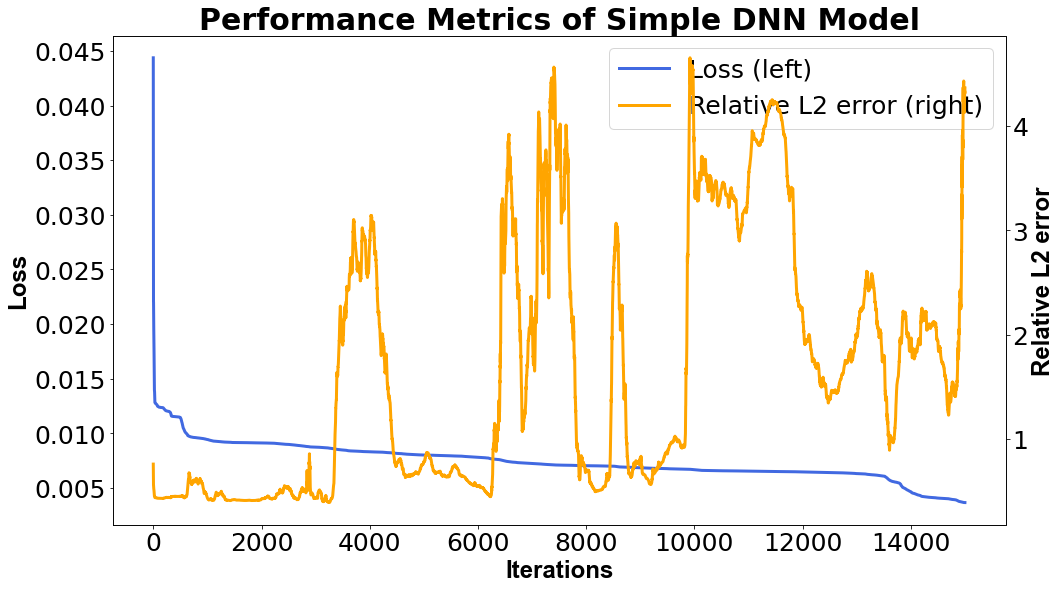

In [17]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax2 = ax1.twinx()
line1 = ax1.plot(loss_record, linewidth = '3', color = "royalblue", label='Loss (left)')
line2 = ax2.plot(l2_record, linewidth = '3', color = "orange", label='Relative L2 error (right)')
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right')
plt.title("Performance Metrics of Simple DNN Model", fontsize=30, fontweight="bold")
ax1.set_xlabel("Iterations", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Loss", fontsize=24, fontname = 'Arial', fontweight="bold")
ax2.set_ylabel("Relative L2 error", fontsize=24, fontname = 'Arial', fontweight="bold")
fig.set_size_inches(16, 9)

# 전체 그리드 비교

In [18]:
u_pred = PINN.evaluate(X_u_grid)
u_pred = np.reshape(u_pred,usol.shape,order='F')

y_test = usol
y_pred = u_pred

error_vec = np.linalg.norm((y_test-y_pred),2)/np.linalg.norm(y_test,2)

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

MAE =  1.0599361568507344
MSE =  35.962464161467494
RMSE =  5.9968711976719575
L2 relative error = 54.265611175888274
--------------------------------------------------


Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

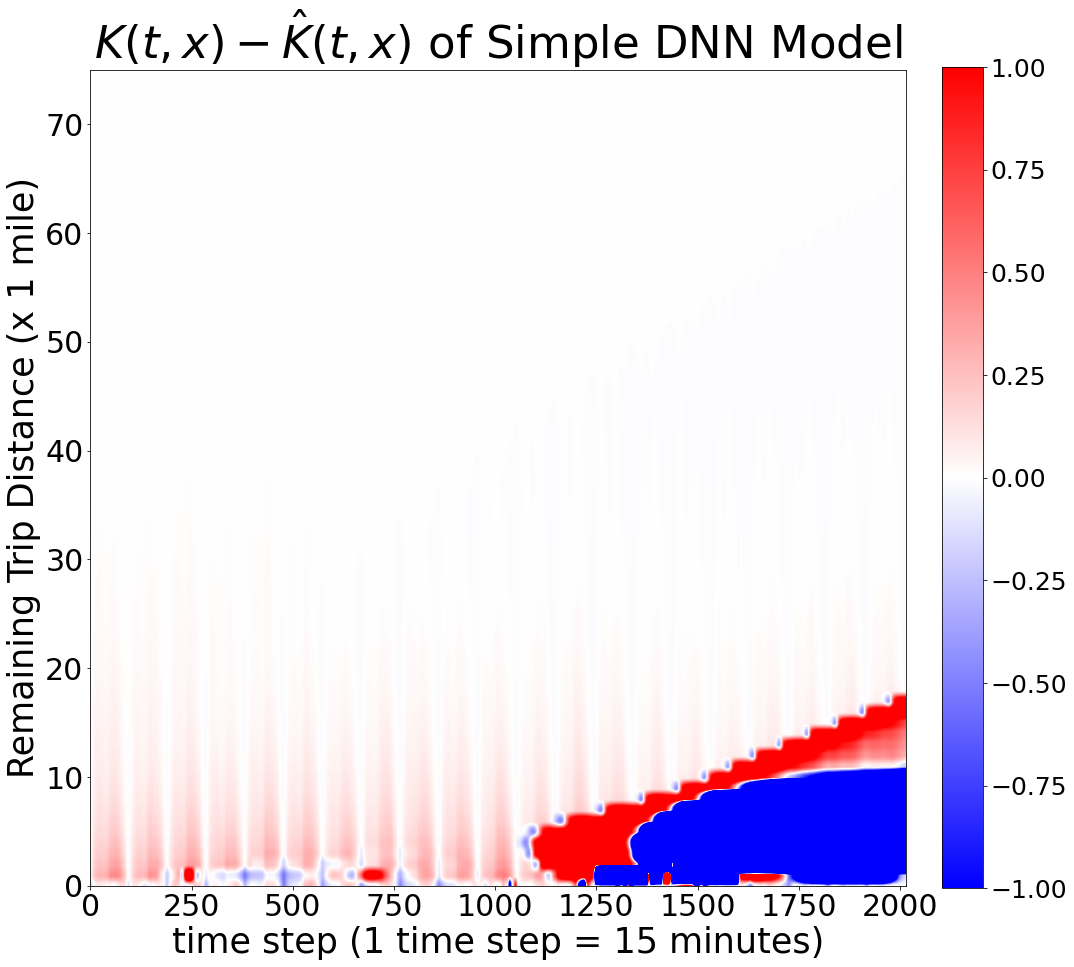

In [ ]:
K_array = np.array(u_pred)
K_array = (usol - K_array)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'bwr')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,75])
plt.clim(-1, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$K(t,x)- \hat{K}(t,x)$' ' of Simple DNN Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

In [ ]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax1.plot(K_array.flatten(), linewidth = '1', color = "royalblue", label='Loss (left)')
plt.title("Observed data - Estimated data(w/ Physics)", fontsize=30, fontweight="bold")
ax1.set_xlabel("Data", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Observed data - Estimated data", fontsize=24, fontname = 'Arial', fontweight="bold")

fig.set_size_inches(16, 9)